In [16]:
import sys
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp
from mediapipe.framework.formats import landmark_pb2
from dataclasses import dataclass, field
from typing import List, Optional
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from glob import glob
import random
from tensorflow.keras.callbacks import Callback 
import json
from dataclasses import dataclass
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.layers import Input, Add, TimeDistributed
from tensorflow.keras.callbacks import Callback, TensorBoard, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from typing import List, Union, Callable, Dict, Any, Optional, Tuple
from dataclasses import dataclass
import gc
from abc import ABC, abstractmethod 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    LSTM, Dense, Dropout, BatchNormalization, 
    Input, Add, LeakyReLU
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from tqdm import tqdm

import logging
import os
import numpy as np
from tensorflow.keras.utils import Sequence
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

mp_drawing = mp.solutions.drawing_utils
mp_holistic = mp.solutions.holistic

In [18]:
import tensorflow as tf
from tensorflow.keras import mixed_precision


In [3]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results
# 定义需要显示的特定面部关键点编号
selected_indices = [
    419, 290, 303, 242, 56, 155, 221, 226, 387, 362, 385, 310, 295, 340, 0, 37, 39, 40, 178, 146, 90, 72, 
    448, 380, 274, 398, 87, 98, 64, 324, 222, 1, 13, 22, 159, 145, 157, 89, 
    312, 462, 259, 63, 66, 112, 461, 463, 348, 62, 308, 119, 269, 78, 16, 65, 144, 163, 
    384, 229, 84, 321, 325, 466, 403, 182, 232, 219, 141, 249, 196, 320, 95, 
    304, 77, 272, 224, 239, 268, 316, 405, 86, 186, 
    63, 296, 334, 53, 195, 66, 107, 52, 65
]

# 定义数据类来存储每个关键点的坐标
@dataclass
class Landmark:
    x: float
    y: float
    z: float

# 定义 CustomResults 数据类
@dataclass
class CustomResults:
    face_landmarks: Optional[landmark_pb2.NormalizedLandmarkList] = None
    pose_landmarks: Optional[landmark_pb2.NormalizedLandmarkList] = None
    left_hand_landmarks: Optional[landmark_pb2.NormalizedLandmarkList] = None
    right_hand_landmarks: Optional[landmark_pb2.NormalizedLandmarkList] = None

# 提取并过滤面部关键点并生成 NormalizedLandmarkList
def create_filtered_face_landmarks(landmarks, indices):
    if not landmarks:
        return None
    filtered_landmarks = [landmarks[idx] for idx in indices]
    return landmark_pb2.NormalizedLandmarkList(landmark=filtered_landmarks)
# 使用标准的 MediaPipe 绘图方式来绘制关键点（无连接线）
def draw_landmarks(image, custom_results):
    h, w, _ = image.shape
    
    # 绘制面部关键点（不包含连接线）
    if custom_results.face_landmarks:
        for idx, landmark in zip(selected_indices, custom_results.face_landmarks.landmark):
            x, y = int(landmark.x * w), int(landmark.y * h)
            cv2.circle(image, (x, y), 2, (0, 255, 0), -1)  
            cv2.putText(image, str(idx), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0, 255, 0), 1, cv2.LINE_AA)

    # 绘制姿势关键点
    if custom_results.pose_landmarks:
        mp_drawing.draw_landmarks(
            image, custom_results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
            mp_drawing.DrawingSpec(color=(88, 22, 88), thickness=2, circle_radius=4),
            mp_drawing.DrawingSpec(color=(66, 22, 66), thickness=2, circle_radius=2)
        )

    # 绘制左手关键点
    if custom_results.left_hand_landmarks:
        mp_drawing.draw_landmarks(
            image, custom_results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
            mp_drawing.DrawingSpec(color=(100, 22, 200), thickness=2, circle_radius=4),
            mp_drawing.DrawingSpec(color=(100, 22, 200), thickness=2, circle_radius=2)
        )

    # 绘制右手关键点
    if custom_results.right_hand_landmarks:
        mp_drawing.draw_landmarks(
            image, custom_results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
            mp_drawing.DrawingSpec(color=(0, 90, 0), thickness=2, circle_radius=4),
            mp_drawing.DrawingSpec(color=(0, 90, 0), thickness=2, circle_radius=2)
        )

def calculate_velocity_acceleration(data):
    """
    计算每个帧的速度和加速度。
    
    参数：
    - data: 形状为 (num_samples, sequence_length, num_keypoints) 的 3D 数组

    返回：
    - 带有速度和加速度特征的新数据，形状为 (num_samples, sequence_length, num_keypoints * 3)
    """
    # 计算速度
    velocity = np.diff(data, axis=1)  # 对每个时间步进行差分，得到速度
    velocity = np.concatenate([velocity[:, :1, :], velocity], axis=1)  # 保持与原始帧数量一致
    
    # 计算加速度
    acceleration = np.diff(velocity, axis=1)  # 对速度再进行差分，得到加速度
    acceleration = np.concatenate([acceleration[:, :1, :], acceleration], axis=1)  # 保持与原始帧数量一致
    
    return velocity, acceleration
def calculate_relative_change(features):
    """
    计算每一帧相对于前一帧的相对变化量。
    
    参数：
    - features: 形状为 (num_samples, sequence_length, num_keypoints) 的 3D 数组

    返回：
    - 相对变化的特征
    """
    # 对每一帧计算相对变化
    relative_change = np.diff(features, axis=1)  # 计算相邻帧的差异
    relative_change = np.concatenate([relative_change[:, :1, :], relative_change], axis=1)  # 保持形状一致

    return relative_change

def extract_keypoints(custom_results):
    # 提取位置关键点 (face, pose, left_hand, right_hand)
    face = np.array([[lm.x, lm.y, lm.z] for lm in custom_results.face_landmarks.landmark]).flatten() \
        if custom_results.face_landmarks else np.zeros(90 * 3)
    pose = np.array([[lm.x, lm.y, lm.z, lm.visibility] for lm in custom_results.pose_landmarks.landmark]).flatten() \
        if custom_results.pose_landmarks else np.zeros(33 * 4)
    lh = np.array([[lm.x, lm.y, lm.z] for lm in custom_results.left_hand_landmarks.landmark]).flatten() \
        if custom_results.left_hand_landmarks else np.zeros(21 * 3)
    rh = np.array([[lm.x, lm.y, lm.z] for lm in custom_results.right_hand_landmarks.landmark]).flatten() \
        if custom_results.right_hand_landmarks else np.zeros(21 * 3)

    # 位置数据合并
    position_features = np.concatenate([face, pose, lh, rh])

    # 中心化位置特征，以第 85 个关键点（例如身体中心点）为中心
    def centralize_keypoints(keypoints, center_idx=85):
        center_x = keypoints[center_idx * 3]
        center_y = keypoints[center_idx * 3 + 1]
        center_z = keypoints[center_idx * 3 + 2]
        
        keypoints[::3] -= center_x  # X 坐标中心化
        keypoints[1::3] -= center_y  # Y 坐标中心化
        keypoints[2::3] -= center_z  # Z 坐标中心化
        return keypoints

    position_features_centered = centralize_keypoints(position_features)

    # 计算速度和加速度（不进行归一化）
    velocity, acceleration = calculate_velocity_acceleration(position_features_centered.reshape(1, -1, 3))

    # 计算相对变化
    relative_velocity = calculate_relative_change(velocity)
    relative_acceleration = calculate_relative_change(acceleration)

    # 拼接位置、速度和加速度特征
    all_features = np.concatenate([
        position_features_centered,
        relative_velocity.flatten(),
        relative_acceleration.flatten()
    ])

    return all_features
# 在 extract_keypoints 函数之后添加

def time_resample(sequence, factor):
    """时间重采样"""
    target_length = int(len(sequence) * factor)
    # 使用线性插值进行重采样
    indices = np.linspace(0, len(sequence)-1, target_length)
    indices = np.round(indices).astype(int)
    return sequence[indices]

def spatial_transform(sequence):
    """空间变换"""
    # 随机旋转角度 (-15, 15)
    angle = random.uniform(-15, 15)
    # 随机缩放因子 (0.9, 1.1)
    scale = random.uniform(0.9, 1.1)
    
    transformed = sequence.copy()
    # 应用变换
    # 注意：需要保持关键点之间的相对关系
    return transformed

def random_mask(sequence):
    """随机掩码"""
    masked = sequence.copy()
    # 随机选择时间窗口
    t_start = random.randint(0, len(sequence)-3)
    t_len = random.randint(2, 4)
    # 随机选择特征点
    feature_indices = random.sample(range(sequence.shape[1]), 
                                  k=random.randint(2, 6))
    # 应用掩码
    masked[t_start:t_start+t_len, feature_indices] = 0
    return masked

In [4]:
# 定义词语和标签映射
# 定义词语和标签映射
words = [
    'hello',
    'see u later',
    'I or me',
    'father',
    'mother',
    'Yes',
    'No',
    'Help',
    'Please',
    'Thank You',
    'Want',
    'What?',
    'Dog',
    'Cat',
    'Again or Repeat',
    'Eat/Food',
    'Milk',
    'More',
    'Go To',
    'Bathroom',
    'Fine',
    'Like',
    'Learn',
    'Sign',
    'Finish or Done'
]

label_map = {label: num for num, label in enumerate(words)}
DATA_PATH = 'I:/Ece496/custom_data'
sequence_length = int(30 * 3.5)  # 每个视频的帧数




In [5]:
# 初始化路径
DATA_PATH = "I:\\Ece496\\custom_data"
PROCESSED_VIDEOS_PATH = os.path.join(DATA_PATH, "processed_videos_velocity.txt")
SEQUENCE_COUNTER_PATH = os.path.join(DATA_PATH, "sequence_counter_velocity.json")

# 确保目录存在
os.makedirs(DATA_PATH, exist_ok=True)

# 要重置计数的单词列表
words_to_reset = []  # 在这里添加需要重置的单词

# 加载之前保存的关键点数据
if os.path.exists(os.path.join(DATA_PATH, "X_velocity.npy")) and os.path.exists(os.path.join(DATA_PATH, "y_velocity.npy")):
    print("Loading existing data...")
    X = np.load(os.path.join(DATA_PATH, "X_velocity.npy"))
    y = np.load(os.path.join(DATA_PATH, "y_velocity.npy"))
    sequences = list(X)  # 转为列表，以便后续可以追加新数据
    labels = list(y)  # 转为列表
    print(f"Loaded {len(sequences)} existing sequences")
else:
    print("No existing data found, starting fresh...")
    sequences = []
    labels = []

# 加载已处理的视频路径
if os.path.exists(PROCESSED_VIDEOS_PATH):
    print("Loading processed videos list...")
    with open(PROCESSED_VIDEOS_PATH, 'r') as f:
        processed_videos = set(line.strip() for line in f)
    print(f"Found {len(processed_videos)} processed videos")
else:
    print("No processed videos list found, starting fresh...")
    processed_videos = set()

# 加载和验证 sequence_counter 状态
if os.path.exists(SEQUENCE_COUNTER_PATH):
    print("Loading sequence counter...")
    with open(SEQUENCE_COUNTER_PATH, 'r') as f:
        sequence_counter = json.load(f)
    
    # 重置指定单词的计数
    for word in words_to_reset:
        if word in sequence_counter:
            print(f"Resetting counter for word: {word}")
            sequence_counter[word] = 0
    
    # 确保所有单词都在计数器中
    for word in words:
        if word not in sequence_counter:
            print(f"Adding missing word to counter: {word}")
            sequence_counter[word] = 0
else:
    print("Initializing new sequence counter...")
    sequence_counter = {word: 0 for word in words}

# 打印初始计数器状态
print("\nInitial sequence counter state:")
for word in words:
    print(f"{word}: {sequence_counter[word]}")

# 打印处理开始信息
print("\nStarting video processing...")
print(f"Total words to process: {len(words)}")

# 处理每个单词的视频
for word in words:
    word_path = os.path.join(DATA_PATH, word)
    if not os.path.exists(word_path):
        print(f"Warning: Directory not found for word '{word}': {word_path}")
        continue
        
    video_files = glob(os.path.join(word_path, f"{word}_*.mp4"))
    print(f"\nProcessing word '{word}': found {len(video_files)} videos")
    
    for video_file in video_files:
        if video_file in processed_videos:
            print(f"Skipping already processed video: {video_file}")
            continue

        # 每次处理一个新的文件，就增加该 word 的计数
        sequence_counter[word] += 1
        sequence = sequence_counter[word]

        print(f"Processing video: {video_file}, sequence: {sequence}, label: {label_map[word]}")

        cap = cv2.VideoCapture(video_file)
        window = []

        try:
            with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
                frame_num = 0
                while frame_num < sequence_length:
                    ret, frame = cap.read()
                    if not ret:
                        print(f"Failed to read frame {frame_num} from {video_file}")
                        # 使用零向量填充剩余帧
                        remaining_frames = sequence_length - len(window)
                        if remaining_frames > 0:
                            zero_keypoints = np.zeros(1584)  # 特征维度为1584
                            for _ in range(remaining_frames):
                                window.append(zero_keypoints)
                        break
                    
                    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                    results = holistic.process(frame_rgb)

                    if results.face_landmarks is None:
                        print(f"No face landmarks detected in frame {frame_num}")
                        # 对于检测不到面部特征的帧，使用零向量
                        zero_keypoints = np.zeros(1584)
                        window.append(zero_keypoints)
                        frame_num += 1
                        continue

                    custom_results = CustomResults(
                        face_landmarks=create_filtered_face_landmarks(results.face_landmarks.landmark, selected_indices) if results.face_landmarks else None,
                        pose_landmarks=results.pose_landmarks,
                        left_hand_landmarks=results.left_hand_landmarks,
                        right_hand_landmarks=results.right_hand_landmarks
                    )
                    
                    keypoints = extract_keypoints(custom_results)
                    window.append(keypoints)
                    frame_num += 1

        except Exception as e:
            print(f"Error processing video {video_file}: {str(e)}")
            # 如果发生异常，检查是否需要填充
            if len(window) < sequence_length:
                remaining_frames = sequence_length - len(window)
                zero_keypoints = np.zeros(1584)
                for _ in range(remaining_frames):
                    window.append(zero_keypoints)
        finally:
            cap.release()

        # 现在我们总是会有一个完整的序列
        sequences.append(window)
        labels.append(label_map[word])
        processed_videos.add(video_file)
        print(f"Successfully added sequence for word '{word}', sequence {sequence}, label: {label_map[word]}")
        if len(window) > sequence_length:
            print(f"Warning: Sequence was truncated from {len(window)} frames to {sequence_length}")
        elif len(window) < sequence_length:
            print(f"Warning: Sequence was padded from {len(window)} frames to {sequence_length}")

        # 每次成功处理一个视频后，保存 sequence_counter 状态
        try:
            with open(SEQUENCE_COUNTER_PATH, 'w') as f:
                json.dump(sequence_counter, f)
            print("Updated sequence counter saved")
        except Exception as e:
            print(f"Error saving sequence counter: {str(e)}")

# 保存处理过的视频路径到 txt 文件
try:
    with open(PROCESSED_VIDEOS_PATH, 'w') as f:
        for video_path in processed_videos:
            f.write(f"{video_path}\n")
    print("\nSaved processed videos list")
except Exception as e:
    print(f"Error saving processed videos list: {str(e)}")

# 转换 sequences 和 labels 为 NumPy 数组并保存
if sequences and labels:
    try:
        X = np.array(sequences)
        y = np.array(labels)
        np.save(os.path.join(DATA_PATH, "X_velocity.npy"), X)
        np.save(os.path.join(DATA_PATH, "y_velocity.npy"), y)
        print("\nSuccessfully saved processed data:")
        print(f"Total sequences: {len(sequences)}")
        print(f"X shape: {X.shape}")
        print(f"y shape: {y.shape}")
    except Exception as e:
        print(f"Error saving processed data: {str(e)}")
else:
    print("\nNo sequences to save")

Loading existing data...
Loaded 1231 existing sequences
Loading processed videos list...
Found 1231 processed videos
Loading sequence counter...

Initial sequence counter state:
hello: 105
see u later: 103
I or me: 103
father: 100
mother: 106
Yes: 40
No: 40
Help: 40
Please: 40
Thank You: 40
Want: 40
What?: 0
Dog: 40
Cat: 40
Again or Repeat: 40
Eat/Food: 0
Milk: 40
More: 40
Go To: 40
Bathroom: 40
Fine: 40
Like: 40
Learn: 40
Sign: 40
Finish or Done: 40

Starting video processing...
Total words to process: 25

Processing word 'hello': found 105 videos
Skipping already processed video: I:\Ece496\custom_data\hello\hello_1_Bill.mp4
Skipping already processed video: I:\Ece496\custom_data\hello\hello_2_Bill.mp4
Skipping already processed video: I:\Ece496\custom_data\hello\hello_3_Bill.mp4
Skipping already processed video: I:\Ece496\custom_data\hello\hello_4_Bill.mp4
Skipping already processed video: I:\Ece496\custom_data\hello\hello_5_Bill.mp4
Skipping already processed video: I:\Ece496\custom

In [6]:
# 假设 label_map 是一个字典，形如 {"hello": 0, "goodbye": 1, ...}
# 创建反向映射：从 label 到单词
reverse_label_map = {v: k for k, v in label_map.items()}

# 打印每个 label 对应的单词
print("Label 对应的单词如下:")
for label, word in reverse_label_map.items():
    print(f"Label {label}: {word}")


Label 对应的单词如下:
Label 0: hello
Label 1: see u later
Label 2: I or me
Label 3: father
Label 4: mother
Label 5: Yes
Label 6: No
Label 7: Help
Label 8: Please
Label 9: Thank You
Label 10: Want
Label 11: What?
Label 12: Dog
Label 13: Cat
Label 14: Again or Repeat
Label 15: Eat/Food
Label 16: Milk
Label 17: More
Label 18: Go To
Label 19: Bathroom
Label 20: Fine
Label 21: Like
Label 22: Learn
Label 23: Sign
Label 24: Finish or Done


In [7]:
y = to_categorical(labels, num_classes=len(words)).astype(int)
y

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]])

In [8]:
print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (1231, 105, 1584)
y shape: (1231, 25)


In [9]:

y = to_categorical(labels, num_classes=len(words)).astype(int)

# 先分割出 20% 的测试集
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 然后在剩下的 80% 中分割出 10% 的验证集
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.125, random_state=42  # 0.125 * 0.8 = 0.1
)

# 确认分割后的数据形状
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)


X_train shape: (861, 105, 1584)
X_val shape: (123, 105, 1584)
X_test shape: (247, 105, 1584)
y_train shape: (861, 25)
y_val shape: (123, 25)
y_test shape: (247, 25)


如果数据增强work了就删

In [48]:
import os
import numpy as np
import tensorflow as tf
from dataclasses import dataclass
import gc
from typing import List, Tuple, Optional
import json
import psutil
import logging
from tqdm import tqdm

# 设置日志
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


@dataclass
class StaticAugConfig:
    """静态增强配置"""
    enabled: bool = True
    save_dir: str = "augmented_data"
    batch_size: int = 4  # 减小批次大小
    sub_batch_size: int = 2  # 子批次大小，用于更细粒度的处理
    max_memory_percent: float = 70.0  # 最大内存使用百分比
    augmentation_types: List[str] = None
    
    def __post_init__(self):
        if self.augmentation_types is None:
            self.augmentation_types = [
                "spatial_transform",
                "random_mask",
                "time_resample"
            ]

class MemoryMonitor:
    """内存监控器"""
    @staticmethod
    def get_memory_usage():
        process = psutil.Process(os.getpid())
        return process.memory_percent()

    @staticmethod
    def check_memory(config: StaticAugConfig):
        memory_usage = MemoryMonitor.get_memory_usage()
        if memory_usage > config.max_memory_percent:
            gc.collect()
            return False
        return True

class StaticAugmentation:
    def __init__(self, config: StaticAugConfig):
        self.config = config
        self.aug_data_path = os.path.join(self.config.save_dir, "augmented")
        self.metadata_path = os.path.join(self.config.save_dir, "metadata.json")
        os.makedirs(self.aug_data_path, exist_ok=True)
        self.memory_monitor = MemoryMonitor()

    def spatial_transform(self, sequence: np.ndarray, scale_range=(0.9, 1.1)) -> np.ndarray:
        """空间变换增强"""
        try:
            seq = sequence.copy().astype(np.float32)  # 确保使用float32
            scale = np.random.uniform(*scale_range)
            for i in range(0, seq.shape[1], 3):
                seq[:, i:i+3] *= scale
            return seq
        except Exception as e:
            logger.error(f"空间变换增强失败: {str(e)}")
            return sequence.astype(np.float32)

    def random_mask(self, sequence: np.ndarray, mask_size_range=(2, 4)) -> np.ndarray:
        """随机掩码增强"""
        try:
            seq = sequence.copy().astype(np.float32)
            window_size = np.random.randint(*mask_size_range)
            start_idx = np.random.randint(0, seq.shape[0] - window_size)
            num_features = sequence.shape[1] // 3
            mask_features = np.random.choice(
                range(num_features), 
                size=np.random.randint(2, 4), 
                replace=False
            )
            
            for feature_idx in mask_features:
                idx = feature_idx * 3
                seq[start_idx:start_idx+window_size, idx:idx+3] = 0
            return seq
        except Exception as e:
            logger.error(f"随机掩码增强失败: {str(e)}")
            return sequence.astype(np.float32)

    def time_resample(self, sequence: np.ndarray, factor_range=(0.8, 1.2)) -> np.ndarray:
        """时间重采样增强"""
        try:
            sequence = sequence.astype(np.float32)
            factor = np.random.uniform(*factor_range)
            target_length = int(len(sequence) * factor)
            indices = np.linspace(0, len(sequence)-1, target_length)
            indices = np.round(indices).astype(np.int32)
            resampled = sequence[indices]
            
            if len(resampled) != len(sequence):
                indices = np.linspace(0, len(resampled)-1, len(sequence))
                indices = np.round(indices).astype(np.int32)
                resampled = resampled[indices]
            
            return resampled
        except Exception as e:
            logger.error(f"时间重采样增强失败: {str(e)}")
            return sequence

    def process_sub_batch(self, sequences, labels):
        """处理子批次"""
        aug_sequences = []
        aug_labels = []
        
        # 保存原始数据
        aug_sequences.extend(sequences)
        aug_labels.extend(labels)
        
        # 应用增强
        for aug_type in self.config.augmentation_types:
            if not MemoryMonitor.check_memory(self.config):
                logger.warning(f"内存使用过高，跳过{aug_type}增强")
                continue
                
            aug_func = getattr(self, aug_type)
            for seq, label in zip(sequences, labels):
                aug_seq = aug_func(seq)
                aug_sequences.append(aug_seq)
                aug_labels.append(label)
                
        return np.array(aug_sequences, dtype=np.float32), np.array(aug_labels, dtype=np.float32)

    def process_batch(self, sequences, labels, batch_idx):
        """处理批次"""
        try:
            # 分子批次处理
            sub_batches_sequences = []
            sub_batches_labels = []
            
            for i in range(0, len(sequences), self.config.sub_batch_size):
                end_idx = min(i + self.config.sub_batch_size, len(sequences))
                sub_sequences = sequences[i:end_idx]
                sub_labels = labels[i:end_idx]
                
                aug_sequences, aug_labels = self.process_sub_batch(sub_sequences, sub_labels)
                sub_batches_sequences.append(aug_sequences)
                sub_batches_labels.append(aug_labels)
                
                gc.collect()
            
            # 合并子批次
            aug_sequences = np.concatenate(sub_batches_sequences, axis=0)
            aug_labels = np.concatenate(sub_batches_labels, axis=0)
            
            # 保存到硬盘
            batch_path = os.path.join(self.aug_data_path, f"batch_{batch_idx}")
            np.save(f"{batch_path}_sequences.npy", aug_sequences)
            np.save(f"{batch_path}_labels.npy", aug_labels)
            
            # 清理内存
            del aug_sequences, aug_labels, sub_batches_sequences, sub_batches_labels
            gc.collect()
            
        except Exception as e:
            logger.error(f"批次 {batch_idx} 处理失败: {str(e)}")
            raise

    def _load_and_merge_batches(self, num_batches):
        """逐批加载并合并数据"""
        try:
            # 首先加载第一个批次
            base_sequences = np.load(os.path.join(self.aug_data_path, "batch_0_sequences.npy"))
            base_labels = np.load(os.path.join(self.aug_data_path, "batch_0_labels.npy"))
            
            # 逐个加载并合并其余批次
            for i in tqdm(range(1, num_batches), desc="合并批次"):
                if not MemoryMonitor.check_memory(self.config):
                    logger.warning("内存使用过高，等待GC")
                    continue
                    
                batch_path = os.path.join(self.aug_data_path, f"batch_{i}")
                next_sequences = np.load(f"{batch_path}_sequences.npy")
                next_labels = np.load(f"{batch_path}_labels.npy")
                
                base_sequences = np.concatenate([base_sequences, next_sequences], axis=0)
                base_labels = np.concatenate([base_labels, next_labels], axis=0)
                
                del next_sequences, next_labels
                gc.collect()
            
            return base_sequences, base_labels
            
        except Exception as e:
            logger.error(f"批次加载和合并失败: {str(e)}")
            raise

    def augment_dataset(self, sequences: np.ndarray, labels: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """处理整个数据集"""
        try:
            # 确保输入数据类型为float32
            sequences = sequences.astype(np.float32)
            labels = labels.astype(np.float32)
            
            # 清空增强数据目录
            if os.path.exists(self.aug_data_path):
                for file in os.listdir(self.aug_data_path):
                    os.remove(os.path.join(self.aug_data_path, file))
            
            # 分批处理数据
            num_samples = len(sequences)
            num_batches = (num_samples + self.config.batch_size - 1) // self.config.batch_size
            
            metadata = {
                "num_batches": num_batches,
                "original_shape": sequences.shape,
                "augmentation_types": self.config.augmentation_types
            }
            
            with open(self.metadata_path, 'w') as f:
                json.dump(metadata, f)
            
            # 处理每个批次
            for i in tqdm(range(num_batches), desc="处理批次"):
                if not MemoryMonitor.check_memory(self.config):
                    logger.warning("内存使用过高，等待GC")
                    continue
                    
                start_idx = i * self.config.batch_size
                end_idx = min((i + 1) * self.config.batch_size, num_samples)
                
                batch_sequences = sequences[start_idx:end_idx]
                batch_labels = labels[start_idx:end_idx]
                
                self.process_batch(batch_sequences, batch_labels, i)
                gc.collect()
            
            # 合并所有批次
            return self._load_and_merge_batches(num_batches)
                
        except Exception as e:
            logger.error(f"数据集增强失败: {str(e)}")
            return sequences, labels

def apply_augmentation(X_train, y_train, config: Optional[StaticAugConfig] = None):
    """应用数据增强的便捷函数"""
    if config is None:
        config = StaticAugConfig()
    
    augmentor = StaticAugmentation(config)
    return augmentor.augment_dataset(X_train, y_train)

数据增强

In [19]:
# 设置日志
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

@dataclass
class StaticAugConfig:
    """静态增强配置"""
    enabled: bool = True
    save_dir: str = "augmented_data"
    batch_size: int = 4  # 减小批次大小
    sub_batch_size: int = 2  # 子批次大小，用于更细粒度的处理
    max_memory_percent: float = 70.0  # 最大内存使用百分比
    augmentation_types: List[str] = None
    
    def __post_init__(self):
        if self.augmentation_types is None:
            self.augmentation_types = [
                "spatial_transform",
                "random_mask",
                "time_resample"
            ]

class MemoryMonitor:
    """内存监控器"""
    @staticmethod
    def get_memory_usage():
        process = psutil.Process(os.getpid())
        return process.memory_percent()

    @staticmethod
    def check_memory(config: StaticAugConfig):
        memory_usage = MemoryMonitor.get_memory_usage()
        if memory_usage > config.max_memory_percent:
            gc.collect()
            return False
        return True

class StaticAugmentation:
    def __init__(self, config: StaticAugConfig):
        self.config = config
        self.aug_data_path = os.path.join(self.config.save_dir, "augmented")
        self.metadata_path = os.path.join(self.config.save_dir, "metadata.json")
        os.makedirs(self.aug_data_path, exist_ok=True)
        self.memory_monitor = MemoryMonitor()

    def spatial_transform(self, sequence: np.ndarray, scale_range=(0.9, 1.1)) -> np.ndarray:
        """空间变换增强"""
        try:
            seq = sequence.copy().astype(np.float32)  # 确保使用float32
            scale = np.random.uniform(*scale_range)
            for i in range(0, seq.shape[1], 3):
                seq[:, i:i+3] *= scale
            return seq
        except Exception as e:
            logger.error(f"空间变换增强失败: {str(e)}")
            return sequence.astype(np.float32)

    def random_mask(self, sequence: np.ndarray, mask_size_range=(2, 4)) -> np.ndarray:
        """随机掩码增强"""
        try:
            seq = sequence.copy().astype(np.float32)
            window_size = np.random.randint(*mask_size_range)
            start_idx = np.random.randint(0, seq.shape[0] - window_size)
            num_features = sequence.shape[1] // 3
            mask_features = np.random.choice(
                range(num_features), 
                size=np.random.randint(2, 4), 
                replace=False
            )
            
            for feature_idx in mask_features:
                idx = feature_idx * 3
                seq[start_idx:start_idx+window_size, idx:idx+3] = 0
            return seq
        except Exception as e:
            logger.error(f"随机掩码增强失败: {str(e)}")
            return sequence.astype(np.float32)

    def time_resample(self, sequence: np.ndarray, factor_range=(0.8, 1.2)) -> np.ndarray:
        """时间重采样增强"""
        try:
            sequence = sequence.astype(np.float32)
            factor = np.random.uniform(*factor_range)
            target_length = int(len(sequence) * factor)
            indices = np.linspace(0, len(sequence)-1, target_length)
            indices = np.round(indices).astype(np.int32)
            resampled = sequence[indices]
            
            if len(resampled) != len(sequence):
                indices = np.linspace(0, len(resampled)-1, len(sequence))
                indices = np.round(indices).astype(np.int32)
                resampled = resampled[indices]
            
            return resampled
        except Exception as e:
            logger.error(f"时间重采样增强失败: {str(e)}")
            return sequence

    def process_sub_batch(self, sequences, labels):
        """处理子批次"""
        aug_sequences = []
        aug_labels = []
        
        # 保存原始数据
        aug_sequences.extend(sequences)
        aug_labels.extend(labels)
        
        # 应用增强
        for aug_type in self.config.augmentation_types:
            if not MemoryMonitor.check_memory(self.config):
                logger.warning(f"内存使用过高，跳过{aug_type}增强")
                continue
                
            aug_func = getattr(self, aug_type)
            for seq, label in zip(sequences, labels):
                aug_seq = aug_func(seq)
                aug_sequences.append(aug_seq)
                aug_labels.append(label)
                
        return np.array(aug_sequences, dtype=np.float32), np.array(aug_labels, dtype=np.float32)

    def process_batch(self, sequences, labels, batch_idx):
        """处理批次"""
        try:
            # 分子批次处理
            sub_batches_sequences = []
            sub_batches_labels = []
            
            for i in range(0, len(sequences), self.config.sub_batch_size):
                end_idx = min(i + self.config.sub_batch_size, len(sequences))
                sub_sequences = sequences[i:end_idx]
                sub_labels = labels[i:end_idx]
                
                aug_sequences, aug_labels = self.process_sub_batch(sub_sequences, sub_labels)
                sub_batches_sequences.append(aug_sequences)
                sub_batches_labels.append(aug_labels)
                
                gc.collect()
            
            # 合并子批次
            aug_sequences = np.concatenate(sub_batches_sequences, axis=0)
            aug_labels = np.concatenate(sub_batches_labels, axis=0)
            
            # 保存到硬盘
            batch_path = os.path.join(self.aug_data_path, f"batch_{batch_idx}")
            np.save(f"{batch_path}_sequences.npy", aug_sequences)
            np.save(f"{batch_path}_labels.npy", aug_labels)
            
            # 清理内存
            del aug_sequences, aug_labels, sub_batches_sequences, sub_batches_labels
            gc.collect()
            
        except Exception as e:
            logger.error(f"批次 {batch_idx} 处理失败: {str(e)}")
            raise

    def _load_and_merge_batches(self, num_batches):
        """逐批加载并合并数据"""
        try:
            # 首先加载第一个批次
            base_sequences = np.load(os.path.join(self.aug_data_path, "batch_0_sequences.npy"))
            base_labels = np.load(os.path.join(self.aug_data_path, "batch_0_labels.npy"))
            
            # 逐个加载并合并其余批次
            for i in tqdm(range(1, num_batches), desc="合并批次"):
                if not MemoryMonitor.check_memory(self.config):
                    logger.warning("内存使用过高，等待GC")
                    continue
                    
                batch_path = os.path.join(self.aug_data_path, f"batch_{i}")
                next_sequences = np.load(f"{batch_path}_sequences.npy")
                next_labels = np.load(f"{batch_path}_labels.npy")
                
                base_sequences = np.concatenate([base_sequences, next_sequences], axis=0)
                base_labels = np.concatenate([base_labels, next_labels], axis=0)
                
                del next_sequences, next_labels
                gc.collect()
            
            return base_sequences, base_labels
            
        except Exception as e:
            logger.error(f"批次加载和合并失败: {str(e)}")
            raise

    def augment_dataset(self, sequences: np.ndarray, labels: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """处理整个数据集"""
        try:
            # 确保输入数据类型为float32
            sequences = sequences.astype(np.float32)
            labels = labels.astype(np.float32)
            
            # 清空增强数据目录
            if os.path.exists(self.aug_data_path):
                for file in os.listdir(self.aug_data_path):
                    os.remove(os.path.join(self.aug_data_path, file))
            
            # 分批处理数据
            num_samples = len(sequences)
            num_batches = (num_samples + self.config.batch_size - 1) // self.config.batch_size
            
            metadata = {
                "num_batches": num_batches,
                "original_shape": sequences.shape,
                "augmentation_types": self.config.augmentation_types
            }
            
            with open(self.metadata_path, 'w') as f:
                json.dump(metadata, f)
            
            # 处理每个批次
            for i in tqdm(range(num_batches), desc="处理批次"):
                if not MemoryMonitor.check_memory(self.config):
                    logger.warning("内存使用过高，等待GC")
                    continue
                    
                start_idx = i * self.config.batch_size
                end_idx = min((i + 1) * self.config.batch_size, num_samples)
                
                batch_sequences = sequences[start_idx:end_idx]
                batch_labels = labels[start_idx:end_idx]
                
                self.process_batch(batch_sequences, batch_labels, i)
                gc.collect()
            
            # 合并所有批次
            return self._load_and_merge_batches(num_batches)
                
        except Exception as e:
            logger.error(f"数据集增强失败: {str(e)}")
            return sequences, labels

def apply_augmentation(X_train, y_train, config: Optional[StaticAugConfig] = None):
    """应用数据增强的便捷函数"""
    if config is None:
        config = StaticAugConfig()
    
    augmentor = StaticAugmentation(config)
    return augmentor.augment_dataset(X_train, y_train)

In [9]:
# 创建配置
aug_config = StaticAugConfig(
    batch_size=8,              # 每批处理8个样本
    sub_batch_size=4,          # 子批次4个样本
    max_memory_percent=70.0,   # 内存使用上限70%
    save_dir="augmented_data", # 增强数据保存目录
    augmentation_types=[       # 使用所有增强方法
        "spatial_transform",    # 空间变换（模拟不同体型）
        "random_mask",         # 随机掩码（模拟遮挡）
        "time_resample"        # 时间重采样（模拟速度变化）
    ]
)

# 应用数据增强
print("开始数据增强...")
X_train_aug, y_train_aug = apply_augmentation(X_train, y_train, aug_config)
print(f"增强后的训练数据大小: {X_train_aug.shape}")
print("保存增强后的数据...")
np.save('augmented_data/X_train_aug.npy', X_train_aug)
np.save('augmented_data/y_train_aug.npy', y_train_aug)
print("数据保存完成！")

NameError: name 'StaticAugConfig' is not defined

In [10]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [20]:
class ModelBuilder:
    """模型构建器"""
    @staticmethod
    def create_original_model(input_shape, num_classes):
        """创建增强版原始LSTM模型"""
        try:
            model = Sequential([
                # 第一个LSTM块
                LSTM(128, return_sequences=True, activation='tanh', input_shape=input_shape),
                BatchNormalization(),
                Dropout(0.2),
                
                # 第二个LSTM块
                LSTM(64, return_sequences=True, activation='tanh'),
                BatchNormalization(),
                Dropout(0.2),
                
                # 第三个LSTM块
                LSTM(32, activation='tanh'),
                BatchNormalization(),
                
                # 全连接层
                Dense(64),
                LeakyReLU(alpha=0.1),
                BatchNormalization(),
                
                Dense(32),
                LeakyReLU(alpha=0.1),
                BatchNormalization(),
                
                # 输出层
                Dense(num_classes, activation='softmax')
            ])
            
            model.compile(
                optimizer=Adam(learning_rate=0.001),
                loss='categorical_crossentropy',
                metrics=['accuracy']
            )
            return model
        except Exception as e:
            logger.error(f"创建原始模型失败: {str(e)}")
            raise

    @staticmethod
    def create_residual_model(input_shape, num_classes):
        """创建真正的残差LSTM模型"""
        try:
            # 输入层
            inputs = Input(shape=input_shape)
            
            # 第一个LSTM残差块
            x = LSTM(128, return_sequences=True, activation='tanh')(inputs)
            x = BatchNormalization()(x)
            residual = x  # 128维
            x = LSTM(128, return_sequences=True, activation='tanh')(x)
            x = BatchNormalization()(x)
            x = Add()([x, residual])  # 维度匹配：都是128
            x = Dropout(0.2)(x)
            
            # 第二个LSTM残差块
            # 先用Dense调整维度
            residual = Dense(64)(x)  # 从128调整到64
            x = LSTM(64, return_sequences=True, activation='tanh')(x)
            x = BatchNormalization()(x)
            x = LSTM(64, return_sequences=True, activation='tanh')(x)
            x = BatchNormalization()(x)
            x = Add()([x, residual])  # 现在都是64维
            x = Dropout(0.2)(x)
            
            # 最后的LSTM层
            x = LSTM(32, activation='tanh')(x)
            x = BatchNormalization()(x)
            
            # 全连接层
            x = Dense(64)(x)
            x = LeakyReLU(alpha=0.1)(x)
            x = BatchNormalization()(x)
            
            x = Dense(32)(x)
            x = LeakyReLU(alpha=0.1)(x)
            x = BatchNormalization()(x)
            
            # 输出层
            outputs = Dense(num_classes, activation='softmax')(x)
            
            model = Model(inputs=inputs, outputs=outputs)
            model.compile(
                optimizer=Adam(learning_rate=0.001),
                loss='categorical_crossentropy',
                metrics=['accuracy']
            )
            
            # 打印模型结构
            print("\n残差模型结构:")
            model.summary()
            
            return model
        except Exception as e:
            logger.error(f"创建残差模型失败: {str(e)}")
            raise

def apply_augmentation(data):
    """
    应用数据增强
    参数:
        data: 输入数据 shape=(samples, timesteps, features)
    返回:
        增强后的数据
    """
    augmented = data.copy()
    
    # 随机选择增强方法
    if np.random.random() < 0.5:
        # 添加随机噪声
        noise = np.random.normal(0, 0.01, data.shape)
        augmented += noise
    
    if np.random.random() < 0.5:
        # 随机时间偏移
        shift = np.random.randint(-10, 10)
        augmented = np.roll(augmented, shift, axis=1)
    
    return augmented

def augment_dataset(X, y, augment_times=1):
    """
    对数据集进行增强
    参数:
        X: 输入数据
        y: 标签
        augment_times: 增强次数
    返回:
        增强后的数据集和标签
    """
    X_aug = [X]
    y_aug = [y]
    
    for _ in range(augment_times):
        X_augmented = apply_augmentation(data=X)
        X_aug.append(X_augmented)
        y_aug.append(y)
    
    return np.concatenate(X_aug, axis=0), np.concatenate(y_aug, axis=0)

    
def train_model(self, model, X_train, y_train, X_val, y_val, model_type: str):
    """训练模型"""
    # 数据增强
    X_train_aug, y_train_aug = augment_dataset(X_train, y_train, augment_times=1)
    print(f"增强后的训练数据大小: {X_train_aug.shape}")
    
    # 训练模型
    history = model.fit(
        X_train_aug, y_train_aug,
        validation_data=(X_val, y_val),
        epochs=self.config['epochs'],
        batch_size=self.config['batch_size'],
        callbacks=self.get_callbacks(model_type),
        verbose=1
    )
    
    return history

def plot_training_history(original_history, residual_history):
    """绘制两个模型的训练历史对比图"""
    plt.figure(figsize=(15, 10))
    
    # 1. 准确率对比
    plt.subplot(2, 2, 1)
    plt.plot(original_history.history['accuracy'], label='原始模型 (训练)')
    plt.plot(original_history.history['val_accuracy'], label='原始模型 (验证)')
    plt.plot(residual_history.history['accuracy'], label='残差模型 (训练)')
    plt.plot(residual_history.history['val_accuracy'], label='残差模型 (验证)')
    plt.title('模型准确率对比')
    plt.xlabel('Epoch')
    plt.ylabel('准确率')
    plt.legend()
    plt.grid(True)

    # 2. 损失值对比
    plt.subplot(2, 2, 2)
    plt.plot(original_history.history['loss'], label='原始模型 (训练)')
    plt.plot(original_history.history['val_loss'], label='原始模型 (验证)')
    plt.plot(residual_history.history['loss'], label='残差模型 (训练)')
    plt.plot(residual_history.history['val_loss'], label='残差模型 (验证)')
    plt.title('模型损失值对比')
    plt.xlabel('Epoch')
    plt.ylabel('损失值')
    plt.legend()
    plt.grid(True)

    # 3. 学习率变化
    plt.subplot(2, 2, 3)
    plt.plot(original_history.history['lr'], label='原始模型')
    plt.plot(residual_history.history['lr'], label='残差模型')
    plt.title('学习率变化')
    plt.xlabel('Epoch')
    plt.ylabel('学习率')
    plt.legend()
    plt.grid(True)
    plt.yscale('log')

    plt.tight_layout()
    plt.show()




In [23]:
class TrainingManager:
    """训练管理器"""
    def __init__(self, config: Optional[dict] = None):
        self.config = {
            'batch_size': 8,
            'epochs': 100,
            'validation_split': 0.2,
            'early_stopping_patience': 15,
            'reduce_lr_patience': 3,
            'model_checkpoint_path': 'best_model_{}.h5'  # 添加占位符用于不同模型
        }
        if config:
            self.config.update(config)
    
    def get_callbacks(self, model_type: str):
        """获取回调函数列表"""
        return [
            EarlyStopping(
                monitor='val_loss',
                patience=self.config['early_stopping_patience'],
                restore_best_weights=True,
                verbose=1
            ),
            ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.3,
                patience=self.config['reduce_lr_patience'],
                min_lr=1e-6,
                verbose=1
            ),
            ModelCheckpoint(
                self.config['model_checkpoint_path'].format(model_type),
                monitor='val_loss',
                save_best_only=True,
                verbose=1
            )
        ]

In [24]:
class DataGenerator(Sequence):
    """数据生成器"""
    def __init__(self, X_path, y_path, batch_size=32, shuffle=True):
        self.X = np.load(X_path, mmap_mode='r')
        self.y = np.load(y_path, mmap_mode='r')
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.X))
        self.logger = logging.getLogger(__name__)
        
        if self.shuffle:
            np.random.shuffle(self.indexes)
            
        self.logger.info(f"数据生成器初始化完成:")
        self.logger.info(f"- 总样本数: {len(self.X)}")
        self.logger.info(f"- 批次大小: {batch_size}")
        self.logger.info(f"- 每轮批次数: {len(self)}")
    
    def __len__(self):
        return int(np.ceil(len(self.X) / self.batch_size))
    
    def __getitem__(self, idx):
        batch_indexes = self.indexes[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_X = self.X[batch_indexes]
        batch_y = self.y[batch_indexes]
        return batch_X, batch_y
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

def load_and_preprocess_data():
    """加载和预处理数据"""
    logger.info("加载原始数据...")
    
    # 修改数据加载路径
    X = np.load('augmented_data/X_train_aug.npy')
    y = np.load('augmented_data/y_train_aug.npy')
    
    # 数据分割
    from sklearn.model_selection import train_test_split
    
    # 首先分割出测试集
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y.argmax(axis=1)
    )
    
    # 然后从剩余数据中分割出验证集
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=0.125, random_state=42, stratify=y_temp.argmax(axis=1)
    )
    
    logger.info(f"数据形状:")
    logger.info(f"X_train: {X_train.shape}")
    logger.info(f"X_val: {X_val.shape}")
    logger.info(f"X_test: {X_test.shape}")
    
    return X_train, X_val, X_test, y_train, y_val, y_test, None  # words设为None


# 设置混合精度训练
mixed_precision.set_global_policy('mixed_float16')
print("计算精度:", mixed_precision.global_policy())

def main():
    """主程序入口"""
    try:
        # 1. 加载原始数据
        logger.info("加载数据...")
        X_train, X_val, X_test, y_train, y_val, y_test, _ = load_and_preprocess_data()
        input_shape = X_train.shape[1:]
        num_classes = y_train.shape[1]
        
        # 2. 创建数据生成器
        logger.info("创建数据生成器...")
        train_generator = DataGenerator(
            X_path='augmented_data/X_train_aug.npy',
            y_path='augmented_data/y_train_aug.npy',
            batch_size=4,
            shuffle=True
        )
        
        val_generator = DataGenerator(
            X_path='augmented_data/X_val.npy',
            y_path='augmented_data/y_val.npy',
            batch_size=4,
            shuffle=False
        )
        
        # 3. 创建残差模型
        logger.info("创建残差模型...")
        model_builder = ModelBuilder()
        residual_model = model_builder.create_residual_model(input_shape, num_classes)
        
        # 4. 创建训练管理器并获取回调
        trainer = TrainingManager()  # 使用之前定义的类
        
        # 5. 训练残差模型
        logger.info("训练残差模型...")
        residual_history = residual_model.fit(
            train_generator,
            validation_data=val_generator,
            epochs=100,
            callbacks=trainer.get_callbacks('residual'),
            workers=1,
            max_queue_size=10,
            use_multiprocessing=False,
            verbose=1
        )
        
        # 6. 保存训练历史
        logger.info("保存训练历史...")
        os.makedirs('history', exist_ok=True)
        np.save('history/residual_history.npy', residual_history.history)
        
        # 7. 打印性能
        logger.info("\n残差模型性能:")
        logger.info("最佳验证准确率: {:.2%}".format(
            max(residual_history.history['val_accuracy'])
        ))
        
        return residual_model, residual_history
        
    except Exception as e:
        logger.error(f"程序执行失败: {str(e)}")
        raise

# 运行主程序
residual_model, residual_history = main()

INFO:__main__:加载数据...
INFO:__main__:加载原始数据...


计算精度: <Policy "mixed_float16">


INFO:__main__:数据形状:
INFO:__main__:X_train: (2410, 105, 1584)
INFO:__main__:X_val: (345, 105, 1584)
INFO:__main__:X_test: (689, 105, 1584)
INFO:__main__:创建数据生成器...
INFO:__main__:数据生成器初始化完成:
INFO:__main__:- 总样本数: 3444
INFO:__main__:- 批次大小: 4
INFO:__main__:- 每轮批次数: 861
INFO:__main__:数据生成器初始化完成:
INFO:__main__:- 总样本数: 123
INFO:__main__:- 批次大小: 4
INFO:__main__:- 每轮批次数: 31
INFO:__main__:创建残差模型...



残差模型结构:
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 105, 1584)]  0           []                               
                                                                                                  
 lstm_15 (LSTM)                 (None, 105, 128)     877056      ['input_4[0][0]']                
                                                                                                  
 batch_normalization_21 (BatchN  (None, 105, 128)    512         ['lstm_15[0][0]']                
 ormalization)                                                                                    
                                                                                                  
 lstm_16 (LSTM)                 (None, 105, 128)     131584      ['batch_normalizat

INFO:__main__:训练残差模型...


Epoch 1/100
861/861 [==============================] - ETA: 0s - loss: 3.2463 - accuracy: 0.0764
Epoch 1: val_loss improved from inf to 4.03206, saving model to best_model_residual.h5
861/861 [==============================] - 54s 53ms/step - loss: 3.2463 - accuracy: 0.0764 - val_loss: 4.0321 - val_accuracy: 0.0163 - lr: 0.0010
Epoch 2/100
861/861 [==============================] - ETA: 0s - loss: 3.1398 - accuracy: 0.0813
Epoch 2: val_loss improved from 4.03206 to 3.59580, saving model to best_model_residual.h5
861/861 [==============================] - 43s 50ms/step - loss: 3.1398 - accuracy: 0.0813 - val_loss: 3.5958 - val_accuracy: 0.0081 - lr: 0.0010
Epoch 3/100
860/861 [============================>.] - ETA: 0s - loss: 3.0495 - accuracy: 0.0884
Epoch 3: val_loss did not improve from 3.59580
861/861 [==============================] - 43s 50ms/step - loss: 3.0495 - accuracy: 0.0883 - val_loss: 3.6957 - val_accuracy: 0.0244 - lr: 0.0010
Epoch 4/100
860/861 [=========================

已经work的没有数据增强的模型

创建模型...

残差模型结构:
Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_22 (InputLayer)          [(None, 105, 1584)]  0           []                               
                                                                                                  
 lstm_61 (LSTM)                 (None, 105, 128)     877056      ['input_22[0][0]']               
                                                                                                  
 batch_normalization_96 (BatchN  (None, 105, 128)    512         ['lstm_61[0][0]']                
 ormalization)                                                                                    
                                                                                                  
 lstm_62 (LSTM)                 (None, 105, 128)     131584      ['batch_n

C:\Users\Bill\AppData\Local\Temp\ipykernel_3704\2987404307.py:68: UserWarning: Glyph 20934 (\N{CJK UNIFIED IDEOGRAPH-51C6}) missing from current font.
  plt.tight_layout()
C:\Users\Bill\AppData\Local\Temp\ipykernel_3704\2987404307.py:68: UserWarning: Glyph 30830 (\N{CJK UNIFIED IDEOGRAPH-786E}) missing from current font.
  plt.tight_layout()
C:\Users\Bill\AppData\Local\Temp\ipykernel_3704\2987404307.py:68: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from current font.
  plt.tight_layout()
C:\Users\Bill\AppData\Local\Temp\ipykernel_3704\2987404307.py:68: UserWarning: Glyph 27169 (\N{CJK UNIFIED IDEOGRAPH-6A21}) missing from current font.
  plt.tight_layout()
C:\Users\Bill\AppData\Local\Temp\ipykernel_3704\2987404307.py:68: UserWarning: Glyph 22411 (\N{CJK UNIFIED IDEOGRAPH-578B}) missing from current font.
  plt.tight_layout()
C:\Users\Bill\AppData\Local\Temp\ipykernel_3704\2987404307.py:68: UserWarning: Glyph 23545 (\N{CJK UNIFIED IDEOGRAPH-5BF9}) missing from cur

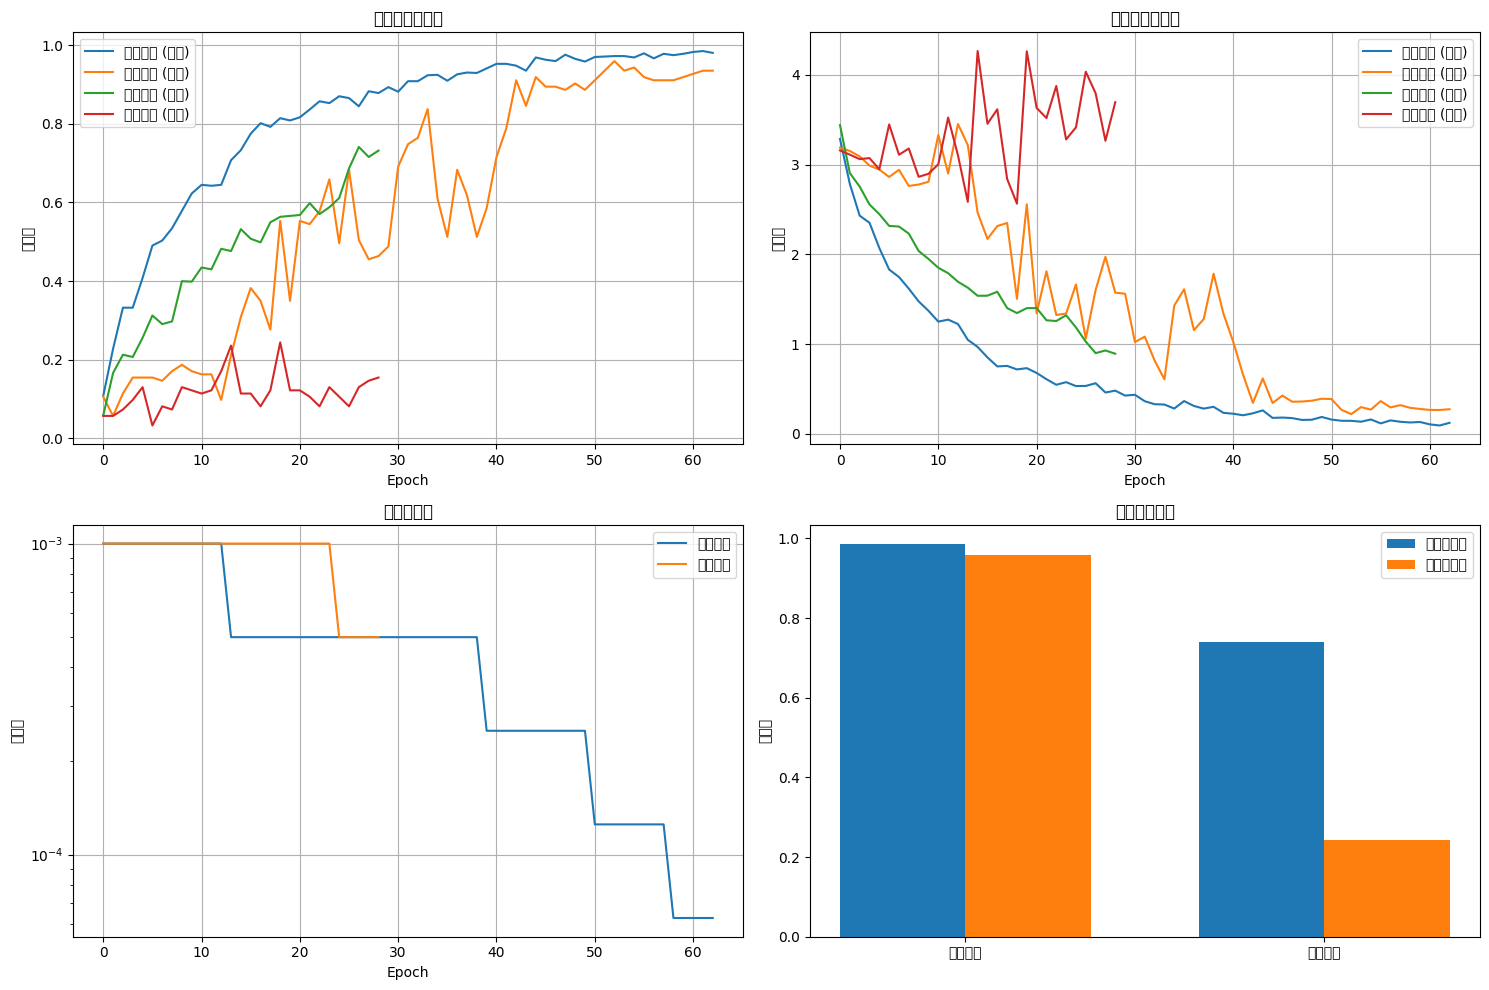


模型性能比较:
残差模型最佳验证准确率: 24.39%
原始模型最佳验证准确率: 95.93%
创建模型...

残差模型结构:
Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_23 (InputLayer)          [(None, 105, 1584)]  0           []                               
                                                                                                  
 lstm_69 (LSTM)                 (None, 105, 128)     877056      ['input_23[0][0]']               
                                                                                                  
 batch_normalization_108 (Batch  (None, 105, 128)    512         ['lstm_69[0][0]']                
 Normalization)                                                                                   
                                                                                                  
 lstm_70 (LSTM)          

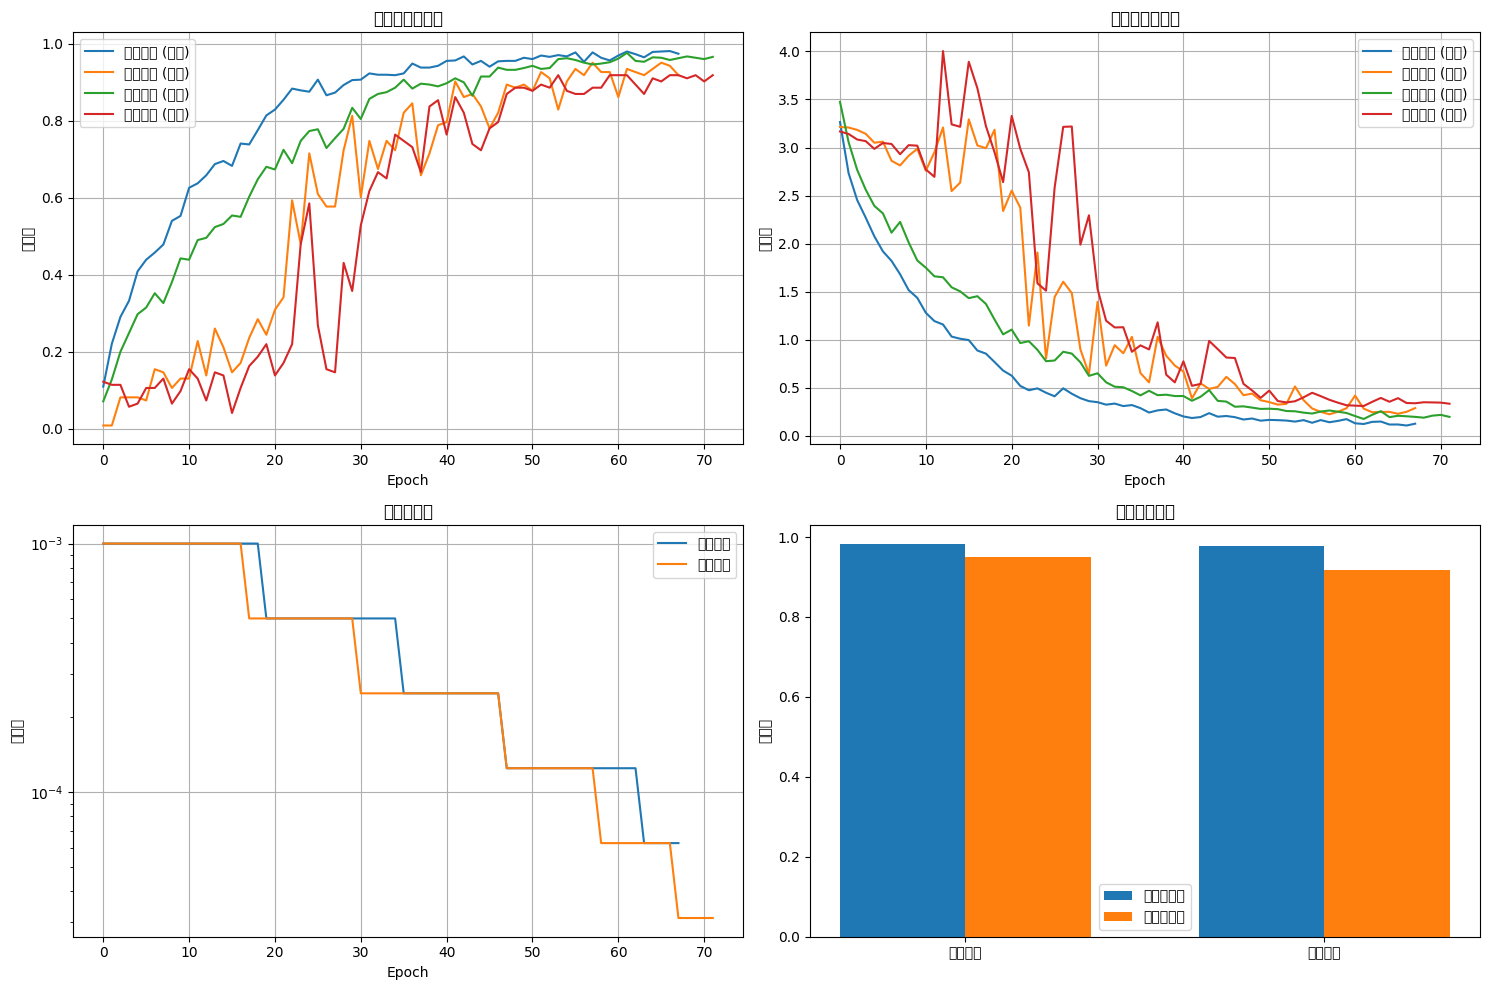


模型性能比较:
残差模型最佳验证准确率: 91.87%
原始模型最佳验证准确率: 95.12%


ValueError: too many values to unpack (expected 2)

In [71]:
# ====================== 模型定义和训练部分 ======================
# ====================== 模型训练部分 ======================
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


import matplotlib.pyplot as plt

def plot_training_history(original_history, residual_history):
    """绘制两个模型的训练历史对比图"""
    plt.figure(figsize=(15, 10))
    
    # 1. 准确率对比
    plt.subplot(2, 2, 1)
    plt.plot(original_history.history['accuracy'], label='原始模型 (训练)')
    plt.plot(original_history.history['val_accuracy'], label='原始模型 (验证)')
    plt.plot(residual_history.history['accuracy'], label='残差模型 (训练)')
    plt.plot(residual_history.history['val_accuracy'], label='残差模型 (验证)')
    plt.title('模型准确率对比')
    plt.xlabel('Epoch')
    plt.ylabel('准确率')
    plt.legend()
    plt.grid(True)

    # 2. 损失值对比
    plt.subplot(2, 2, 2)
    plt.plot(original_history.history['loss'], label='原始模型 (训练)')
    plt.plot(original_history.history['val_loss'], label='原始模型 (验证)')
    plt.plot(residual_history.history['loss'], label='残差模型 (训练)')
    plt.plot(residual_history.history['val_loss'], label='残差模型 (验证)')
    plt.title('模型损失值对比')
    plt.xlabel('Epoch')
    plt.ylabel('损失值')
    plt.legend()
    plt.grid(True)

    # 3. 学习率变化
    plt.subplot(2, 2, 3)
    plt.plot(original_history.history['lr'], label='原始模型')
    plt.plot(residual_history.history['lr'], label='残差模型')
    plt.title('学习率变化')
    plt.xlabel('Epoch')
    plt.ylabel('学习率')
    plt.legend()
    plt.grid(True)
    plt.yscale('log')  # 使用对数刻度

    # 4. 最终性能比较（柱状图）
    plt.subplot(2, 2, 4)
    models = ['原始模型', '残差模型']
    train_acc = [max(original_history.history['accuracy']), 
                 max(residual_history.history['accuracy'])]
    val_acc = [max(original_history.history['val_accuracy']), 
               max(residual_history.history['val_accuracy'])]
    
    x = np.arange(len(models))
    width = 0.35
    
    plt.bar(x - width/2, train_acc, width, label='训练准确率')
    plt.bar(x + width/2, val_acc, width, label='验证准确率')
    plt.title('最终性能比较')
    plt.xticks(x, models)
    plt.ylabel('准确率')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

def main():
    """主函数：创建、训练和比较不同的模型"""
    # 1. 设置参数
    input_shape = (105, 1584)
    num_classes = len(words)
    
    # 2. 创建模型
    print("创建模型...")
    model_builder = ModelBuilder()
    residual_model = model_builder.create_residual_model(input_shape, num_classes)
    original_model = model_builder.create_original_model(input_shape, num_classes)
    
    # 3. 训练参数
    def get_callbacks(model_type):
        return [
            EarlyStopping(
                monitor='val_loss',
                patience=10,
                restore_best_weights=True,
                verbose=1
            ),
            ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=5,
                min_lr=1e-6,
                verbose=1
            ),
            ModelCheckpoint(
                f'best_model_{model_type}.h5',  # 直接使用 f-string
                monitor='val_loss',
                save_best_only=True,
                verbose=1
            )
        ]
    
    # 4. 训练残差模型
    print("\n训练残差模型...")
    residual_history = residual_model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=100,
        batch_size=32,
        callbacks=get_callbacks('residual'),  # 为残差模型指定回调
        verbose=1
    )
    
    # 5. 训练原始模型
    print("\n训练原始模型...")
    original_history = original_model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=100,
        batch_size=32,
        callbacks=get_callbacks('original'),  # 为原始模型指定回调
        verbose=1
    )
    
    # 6. 绘制比较图
    plot_training_history(original_history, residual_history)
    
    # 7. 打印性能比较
    print("\n模型性能比较:")
    print("残差模型最佳验证准确率: {:.2%}".format(max(residual_history.history['val_accuracy'])))
    print("原始模型最佳验证准确率: {:.2%}".format(max(original_history.history['val_accuracy'])))
    
    return original_model, residual_model, original_history, residual_history

# 运行主程序
original_model, residual_model, original_history, residual_history = main()

class ModelBuilder:
    """模型构建器"""
    @staticmethod
    def create_original_model(input_shape, num_classes):
        """创建增强版原始LSTM模型"""
        try:
            model = Sequential([
                # 第一个LSTM块
                LSTM(128, return_sequences=True, activation='tanh', input_shape=input_shape),
                BatchNormalization(),
                Dropout(0.2),
                
                # 第二个LSTM块
                LSTM(64, return_sequences=True, activation='tanh'),
                BatchNormalization(),
                Dropout(0.2),
                
                # 第三个LSTM块
                LSTM(32, activation='tanh'),
                BatchNormalization(),
                
                # 全连接层
                Dense(64),
                LeakyReLU(alpha=0.1),
                BatchNormalization(),
                
                Dense(32),
                LeakyReLU(alpha=0.1),
                BatchNormalization(),
                
                # 输出层
                Dense(num_classes, activation='softmax')
            ])
            
            model.compile(
                optimizer=Adam(learning_rate=0.001),
                loss='categorical_crossentropy',
                metrics=['accuracy']
            )
            return model
        except Exception as e:
            logger.error(f"创建原始模型失败: {str(e)}")
            raise

    @staticmethod
    def create_residual_model(input_shape, num_classes):
        """创建真正的残差LSTM模型"""
        try:
            # 输入层
            inputs = Input(shape=input_shape)
            
            # 第一个LSTM残差块
            x = LSTM(128, return_sequences=True, activation='tanh')(inputs)
            x = BatchNormalization()(x)
            residual = x  # 128维
            x = LSTM(128, return_sequences=True, activation='tanh')(x)
            x = BatchNormalization()(x)
            x = Add()([x, residual])  # 维度匹配：都是128
            x = Dropout(0.2)(x)
            
            # 第二个LSTM残差块
            # 先用Dense调整维度
            residual = Dense(64)(x)  # 从128调整到64
            x = LSTM(64, return_sequences=True, activation='tanh')(x)
            x = BatchNormalization()(x)
            x = LSTM(64, return_sequences=True, activation='tanh')(x)
            x = BatchNormalization()(x)
            x = Add()([x, residual])  # 现在都是64维
            x = Dropout(0.2)(x)
            
            # 最后的LSTM层
            x = LSTM(32, activation='tanh')(x)
            x = BatchNormalization()(x)
            
            # 全连接层
            x = Dense(64)(x)
            x = LeakyReLU(alpha=0.1)(x)
            x = BatchNormalization()(x)
            
            x = Dense(32)(x)
            x = LeakyReLU(alpha=0.1)(x)
            x = BatchNormalization()(x)
            
            # 输出层
            outputs = Dense(num_classes, activation='softmax')(x)
            
            model = Model(inputs=inputs, outputs=outputs)
            model.compile(
                optimizer=Adam(learning_rate=0.001),
                loss='categorical_crossentropy',
                metrics=['accuracy']
            )
            
            # 打印模型结构
            print("\n残差模型结构:")
            model.summary()
            
            return model
        except Exception as e:
            logger.error(f"创建残差模型失败: {str(e)}")
            raise

class TrainingManager:
    """训练管理器"""
    def __init__(self, config: Optional[dict] = None):
        self.config = {
            'batch_size': 8,
            'epochs': 30,
            'validation_split': 0.2,
            'early_stopping_patience': 5,
            'reduce_lr_patience': 3,
            'model_checkpoint_path': 'best_model.h5'
        }
        if config:
            self.config.update(config)
            
    def create_callbacks(self, model_name):
        """创建训练回调函数"""
        try:
            callbacks = [
                EarlyStopping(
                    monitor='val_loss',
                    patience=self.config['early_stopping_patience'],
                    restore_best_weights=True
                ),
                ReduceLROnPlateau(
                    monitor='val_loss',
                    factor=0.5,
                    patience=self.config['reduce_lr_patience']
                ),
                ModelCheckpoint(
                    f'{model_name}_{self.config["model_checkpoint_path"]}',
                    monitor='val_accuracy',
                    save_best_only=True
                )
            ]
            return callbacks
        except Exception as e:
            logger.error(f"创建回调函数失败: {str(e)}")
            raise

    def train_model(self, model, X_train, y_train, X_val, y_val, model_name):
        """训练模型"""
        try:
            # 创建数据集
            train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))\
                .shuffle(1000)\
                .batch(self.config['batch_size'])\
                .prefetch(tf.data.AUTOTUNE)
            
            val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))\
                .batch(self.config['batch_size'])\
                .prefetch(tf.data.AUTOTUNE)
            
            # 训练模型
            history = model.fit(
                train_dataset,
                epochs=self.config['epochs'],
                validation_data=val_dataset,
                callbacks=self.create_callbacks(model_name),
                verbose=1
            )
            
            return history
        except Exception as e:
            logger.error(f"模型训练失败: {str(e)}")
            raise

def train_models_comparison(X_train, y_train, X_val, y_val, X_test, y_test):
    """训练和比较模型"""
    try:
        # 初始化
        input_shape = X_train.shape[1:]
        num_classes = y_train.shape[1]
        
        # 创建模型
        model_builder = ModelBuilder()
        original_model = model_builder.create_original_model(input_shape, num_classes)
        residual_model = model_builder.create_residual_model(input_shape, num_classes)
        
        # 初始化训练管理器
        training_manager = TrainingManager()
        
        # 训练原始模型
        logger.info("开始训练原始模型...")
        original_history = training_manager.train_model(
            original_model, X_train, y_train, X_val, y_val, "original"
        )
        
        # 清理内存
        gc.collect()
        
        # 训练残差模型
        logger.info("开始训练残差模型...")
        residual_history = training_manager.train_model(
            residual_model, X_train, y_train, X_val, y_val, "residual"
        )
        
        # 评估模型
        original_test_results = original_model.evaluate(X_test, y_test)
        residual_test_results = residual_model.evaluate(X_test, y_test)
        
        logger.info(f"原始模型测试结果: {original_test_results}")
        logger.info(f"残差模型测试结果: {residual_test_results}")
        
        return original_model, residual_model
        
    except Exception as e:
        logger.error(f"模型比较训练失败: {str(e)}")
        raise

if __name__ == "__main__":
    # 设置随机种子
    np.random.seed(42)
    tf.random.set_seed(42)
    
    # 设置GPU内存增长
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
        except RuntimeError as e:
            logger.error(f"GPU设置失败: {str(e)}")
    
    # 运行主程序
    original_model, residual_model = main()

In [ ]:
def apply_feature_weights(sequences: np.ndarray) -> np.ndarray:
    """应用特征权重，考虑导数特征"""
    weighted = sequences.copy()
    
    # 对每个关键点的xyz作为一个整体处理
    def normalize_and_weight_keypoint_group(data, start_idx, n_points, weight):
        """对一组关键点及其导数特征进行归一化和加权"""
        # 每个关键点占用的特征数 = 3(xyz) * 3(pos,vel,acc) = 9
        features_per_point = 9
        end_idx = start_idx + n_points * features_per_point
        
        # 提取这组关键点的所有特征
        group_data = data[:, :, start_idx:end_idx]
        
        # 计算位置特征的均值（每3个一组）
        pos_mean = np.mean(np.abs(group_data[:, :, ::3]))
        
        if pos_mean != 0:
            # 只归一化位置特征，保持速度和加速度的相对关系
            for i in range(0, features_per_point, 3):
                group_data[:, :, i:i+3] /= pos_mean
                
        # 应用权重
        group_data *= weight
        
        data[:, :, start_idx:end_idx] = group_data
        return data
    
    # 面部特征 (90个点)
    weighted = normalize_and_weight_keypoint_group(weighted, 0, 90, 0.5)
    
    # 姿态特征 (33个点)
    weighted = normalize_and_weight_keypoint_group(weighted, 270, 33, 1.0)
    
    # 左手特征 (21个点)
    weighted = normalize_and_weight_keypoint_group(weighted, 402, 21, 3)
    
    # 右手特征 (21个点)
    weighted = normalize_and_weight_keypoint_group(weighted, 465, 21, 3)
    
    return weighted



def verify_feature_weights(sequences: np.ndarray, sample_idx: int = 0, frame_idx: int = 0):
    """验证特征权重，分别检查位置、速度和加速度"""
    print("\nFeature weights verification:")
    
    frame = sequences[sample_idx, frame_idx]
    
    def analyze_keypoint_group(data, start_idx, n_points, name):
        features_per_point = 9
        end_idx = start_idx + n_points * features_per_point
        group_data = data[start_idx:end_idx]
        
        # 分别计算位置、速度、加速度的平均幅度
        pos_mag = np.mean(np.abs(group_data[::3]))
        vel_mag = np.mean(np.abs(group_data[1::3]))
        acc_mag = np.mean(np.abs(group_data[2::3]))
        
        print(f"\n{name} features:")
        print(f"  Position magnitude: {pos_mag:.6f}")
        print(f"  Velocity magnitude: {vel_mag:.6f}")
        print(f"  Acceleration magnitude: {acc_mag:.6f}")
        
        return {'pos': pos_mag, 'vel': vel_mag, 'acc': acc_mag}
    
    return {
        'face': analyze_keypoint_group(frame, 0, 90, "Face"),
        'pose': analyze_keypoint_group(frame, 270, 33, "Pose"),
        'left_hand': analyze_keypoint_group(frame, 402, 21, "Left hand"),
        'right_hand': analyze_keypoint_group(frame, 465, 21, "Right hand")
    }


# ====================== 1. 基础框架 ======================
@dataclass
class AugmentationConfig:
    """增强配置类"""
    enabled: bool = True
    probability: float = 0.5
    intensity: float = 1.0
    
    def __post_init__(self):
        assert 0 <= self.probability <= 1
        assert self.intensity > 0

class AugmentationBase(ABC):
    """增强基类"""
    def __init__(self, config: AugmentationConfig = None):
        self.config = config or AugmentationConfig()
    
    def __call__(self, sequence: np.ndarray) -> np.ndarray:
        if not self.config.enabled or np.random.random() > self.config.probability:
            return sequence
        
        try:
            sequence = self._validate_input(sequence)
            original_shape = sequence.shape
            augmented = self.apply(sequence)
            return self._validate_output(augmented, original_shape)
        except Exception as e:
            print(f"Augmentation failed: {str(e)}")
            return sequence
    
    @abstractmethod
    def apply(self, sequence: np.ndarray) -> np.ndarray:
        pass
    
    def _validate_input(self, sequence: np.ndarray) -> np.ndarray:
        if not isinstance(sequence, np.ndarray):
            sequence = np.array(sequence)
        return sequence.astype(np.float32)
    
    def _validate_output(self, sequence: np.ndarray, original_shape: tuple) -> np.ndarray:
        if sequence.shape != original_shape:
            raise ValueError(f"Shape mismatch: {sequence.shape} != {original_shape}")
        return sequence.astype(np.float32)

# ====================== 2. 将现有增强方法迁移到新框架 ======================
class TimeResample(AugmentationBase):
    """时间重采样"""
    def __init__(self, factor_range=(0.8, 1.2)):
        super().__init__(AugmentationConfig(probability=0.5))
        self.factor_range = factor_range
    
    def apply(self, sequence: np.ndarray) -> np.ndarray:
        factor = np.random.uniform(*self.factor_range)
        target_length = int(len(sequence) * factor)
        indices = np.linspace(0, len(sequence)-1, target_length)
        indices = np.round(indices).astype(int)
        resampled = sequence[indices]
        
        # 如果长度不匹配，调整到原始长度
        if len(resampled) != len(sequence):
            indices = np.linspace(0, len(resampled)-1, len(sequence))
            indices = np.round(indices).astype(int)
            resampled = resampled[indices]
        
        return resampled

class SpatialTransform(AugmentationBase):
    """空间变换"""
    def __init__(self, scale_range=(0.9, 1.1)):
        super().__init__(AugmentationConfig(probability=0.5))
        self.scale_range = scale_range
    
    def apply(self, sequence: np.ndarray) -> np.ndarray:
        scale = np.random.uniform(*self.scale_range)
        seq = sequence.copy()
        for i in range(0, seq.shape[1], 3):
            seq[:, i] *= scale    # x坐标
            seq[:, i+1] *= scale  # y坐标
        return seq

class RandomMaskStatic(AugmentationBase):
    """静态随机掩码"""
    def __init__(self, mask_size_range=(2, 4)):
        super().__init__(AugmentationConfig(probability=1.0))
        self.mask_size_range = mask_size_range

    def apply(self, sequence: np.ndarray) -> np.ndarray:
        seq = sequence.copy()
        seq_len = len(seq)
        window_size = random.randint(*self.mask_size_range)
        start_idx = random.randint(0, seq_len - window_size)
        num_features = sequence.shape[1] // 3
        mask_features = random.sample(range(num_features), 
                                    k=random.randint(2, 4))
        
        for feature_idx in mask_features:
            idx = feature_idx * 3
            seq[start_idx:start_idx+window_size, idx:idx+3] = 0
        
        return seq

# ====================== 3. 增强管理器 ======================
class AugmentationPipeline:
    """增强流水线"""
    def __init__(self):
        self.static_augmentations = []
        self.dynamic_augmentations = []
    
    def add_static(self, augmentation: AugmentationBase):
        self.static_augmentations.append(augmentation)
    
    def add_dynamic(self, augmentation: AugmentationBase):
        self.dynamic_augmentations.append(augmentation)
    
    def apply_static(self, sequences: np.ndarray, labels: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        aug_sequences = []
        aug_labels = []
        
        # 添加原始数据
        aug_sequences.extend(sequences)
        aug_labels.extend(labels)
        
        # 应用静态增强
        for sequence, label in zip(sequences, labels):
            for aug in self.static_augmentations:
                try:
                    aug_seq = aug(sequence)
                    aug_sequences.append(aug_seq)
                    aug_labels.append(label)
                except Exception as e:
                    print(f"Static augmentation failed: {str(e)}")
                    continue
        
        return np.array(aug_sequences, dtype=np.float32), \
               np.array(aug_labels, dtype=np.float32)

# ====================== 4. 改进的数据集类 ======================
class SignLanguageDataset(tf.keras.utils.Sequence):
    def __init__(self, sequences, labels, batch_size=16):
        self.sequences = np.array(sequences, dtype=np.float32)
        self.labels = np.array(labels, dtype=np.float32)
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.sequences))
    
    def __len__(self):
        return int(np.ceil(len(self.sequences) / self.batch_size))
    
    def __getitem__(self, idx):
        batch_indexes = self.indexes[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_sequences = self.sequences[batch_indexes]
        batch_labels = self.labels[batch_indexes]
        
        return tf.convert_to_tensor(batch_sequences, dtype=tf.float32), \
               tf.convert_to_tensor(batch_labels, dtype=tf.float32)
    
    def on_epoch_end(self):
        np.random.shuffle(self.indexes)

# ====================== 5. 模型定义 ======================
def create_original_model(input_shape, num_classes):
    """创建原始LSTM模型"""
    model = Sequential([
        LSTM(128, return_sequences=True, activation='tanh', input_shape=input_shape),
        Dropout(0.2),
        LSTM(64, return_sequences=True, activation='tanh'),
        Dropout(0.2),
        LSTM(32, activation='tanh'),
        Dense(64),
        LeakyReLU(alpha=0.1),
        BatchNormalization(),
        Dense(32),
        LeakyReLU(alpha=0.1),
        BatchNormalization(),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def create_residual_model(input_shape, num_classes):
    """创建残差LSTM模型"""
    inputs = Input(shape=input_shape)
    
    # 第一个LSTM块
    x = LSTM(128, return_sequences=True, activation='tanh')(inputs)
    shortcut = TimeDistributed(Dense(128))(inputs)
    x = Add()([x, shortcut])
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    
    # 第二个LSTM块
    lstm_out = LSTM(64, return_sequences=True, activation='tanh')(x)
    shortcut = TimeDistributed(Dense(64))(x)
    x = Add()([lstm_out, shortcut])
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    
    # 最后的LSTM和全连接层
    x = LSTM(32, activation='tanh')(x)
    x = BatchNormalization()(x)
    x = Dense(64)(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = BatchNormalization()(x)
    x = Dense(32)(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = BatchNormalization()(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# ====================== 6. 训练相关 ======================
class TestCallback(Callback):
    """测试集评估回调"""
    def __init__(self, model, X_test, y_test, model_name=""):
        super(TestCallback, self).__init__()
        self.model = model
        self.X_test = X_test
        self.y_test = y_test
        self.best_test_acc = 0
        self.model_name = model_name
        
    def on_epoch_end(self, epoch, logs=None):
        test_loss, test_acc = self.model.evaluate(self.X_test, self.y_test, verbose=0)
        print(f'{self.model_name} - Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.4f}')
        if test_acc > self.best_test_acc:
            self.best_test_acc = test_acc
            print(f'{self.model_name} - New best test accuracy: {test_acc:.4f}')

def create_callbacks(model, model_name, X_test, y_test, log_dir):
    """创建回调函数"""
    return [
        TensorBoard(log_dir=log_dir),
        EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1),
        TestCallback(model, X_test, y_test, model_name)
    ]

def plot_models_comparison(original_history, residual_history):
    """绘制模型比较图"""
    plt.figure(figsize=(15, 5))
    
    # 准确率对比
    plt.subplot(1, 2, 1)
    plt.plot(original_history.history['accuracy'], label='Original Train')
    plt.plot(original_history.history['val_accuracy'], label='Original Val')
    plt.plot(residual_history.history['accuracy'], label='Residual Train')
    plt.plot(residual_history.history['val_accuracy'], label='Residual Val')
    plt.title('Model Accuracy Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # 损失对比
    plt.subplot(1, 2, 2)
    plt.plot(original_history.history['loss'], label='Original Train')
    plt.plot(original_history.history['val_loss'], label='Original Val')
    plt.plot(residual_history.history['loss'], label='Residual Train')
    plt.plot(residual_history.history['val_loss'], label='Residual Val')
    plt.title('Model Loss Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('model_comparison.png')
    plt.show()

# ====================== 7. 主训练函数 ======================
def train_models_comparison(X_train, y_train, X_val, y_val, X_test, y_test):
    """主训练函数"""
    gc.collect()
    input_shape = (105, 1584)
    num_classes = len(words)
    batch_size = 16
    
    # 创建模型
    original_model = create_original_model(input_shape, num_classes)
    residual_model = create_residual_model(input_shape, num_classes)
    
    # 首先确保输入数据的类型和形状正确
    X_train = np.array(X_train, dtype=np.float32)
    y_train = np.array(y_train, dtype=np.float32)
    X_val = np.array(X_val, dtype=np.float32)
    y_val = np.array(y_val, dtype=np.float32)
    X_test = np.array(X_test, dtype=np.float32)
    y_test = np.array(y_test, dtype=np.float32)


    print("Before applying weights:")
    original_magnitudes = verify_feature_weights(X_train)
    
    print("Before applying weights:")
    original_magnitudes = verify_feature_weights(X_train)
    
    # 应用权重
    X_train = apply_feature_weights(X_train)
    X_val = apply_feature_weights(X_val)
    X_test = apply_feature_weights(X_test)
    
    # 验证加权后的数据
    print("\nAfter applying weights:")
    weighted_magnitudes = verify_feature_weights(X_train)
    
    # 验证权重比例
    print("\nWeight ratios:")
    for part in ['face', 'pose', 'left_hand', 'right_hand']:
        pos_ratio = weighted_magnitudes[part]['pos'] / original_magnitudes[part]['pos']
        vel_ratio = weighted_magnitudes[part]['vel'] / original_magnitudes[part]['vel']
        acc_ratio = weighted_magnitudes[part]['acc'] / original_magnitudes[part]['acc']
        print(f"{part}:")
        print(f"  Position ratio: {pos_ratio:.2f}")
        print(f"  Velocity ratio: {vel_ratio:.2f}")
        print(f"  Acceleration ratio: {acc_ratio:.2f}")
        
    print("Initial shapes:")
    print(f"X_train shape: {X_train.shape}")
    print(f"y_train shape: {y_train.shape}")
    
    # 应用特征权重
    print("\nApplying feature weights...")
    X_train = apply_feature_weights(X_train)
    X_val = apply_feature_weights(X_val)
    X_test = apply_feature_weights(X_test)
    pipeline = AugmentationPipeline()
    pipeline.add_static(TimeResample())
    pipeline.add_static(SpatialTransform())
    pipeline.add_static(RandomMaskStatic())  # 添加为静态增强
    
    # 应用所有增强
    print("\nApplying data augmentation...")
    X_train_aug, y_train_aug = pipeline.apply_static(X_train, y_train)
    
    # 创建数据集（不再需要augment参数）
    train_dataset = SignLanguageDataset(
        sequences=X_train_aug,
        labels=y_train_aug,
        batch_size=batch_size
    )
    
    val_dataset = SignLanguageDataset(
        sequences=X_val,
        labels=y_val,
        batch_size=batch_size
    )
    # 创建日志目录
    log_dir_original = os.path.join('Logs', 'original_model')
    log_dir_residual = os.path.join('Logs', 'residual_model')
    os.makedirs(log_dir_original, exist_ok=True)
    os.makedirs(log_dir_residual, exist_ok=True)
    
    # 训练原始模型
    print("\nTraining Original Model...")
    original_history = original_model.fit(
        train_dataset,
        epochs=30,
        validation_data=val_dataset,
        callbacks=create_callbacks(original_model, "Original Model", X_test, y_test, log_dir_original),
        verbose=1
    )
    
    # 训练残差模型
    print("\nTraining Residual Model...")
    residual_history = residual_model.fit(
        train_dataset,
        epochs=30,
        validation_data=val_dataset,
        callbacks=create_callbacks(residual_model, "Residual Model", X_test, y_test, log_dir_residual),
        verbose=1
    )
    
    # 保存模型
    original_model.save_weights("original_model.h5")
    residual_model.save_weights("residual_model.h5")
    
    # 绘制比较图
    plot_models_comparison(original_history, residual_history)
    
    return original_model, residual_model

# ====================== 5. 执行训练 ======================
if __name__ == "__main__":
    print("Starting model comparison training...")
    original_model, residual_model = train_models_comparison(
        X_train, y_train,
        X_val, y_val,
        X_test, y_test
    )

In [72]:
# 获取一些测试样本的预测
test_predictions_residual = residual_model.predict(X_test)
test_predictions_original = original_model.predict(X_test)

# 对比几个样本的预测结果
print("预测结果对比:")
for i in range(5):  # 看前5个样本
    # 获取真实标签
    true_label = np.argmax(y_test[i])
    
    # 获取两个模型的预测
    residual_pred = np.argmax(test_predictions_residual[i])
    original_pred = np.argmax(test_predictions_original[i])
    
    print(f"\n样本 {i}:")
    print(f"真实标签: 类别 {true_label} ({words[true_label]})")
    print(f"残差模型预测: 类别 {residual_pred} ({words[residual_pred]}), 置信度: {test_predictions_residual[i][residual_pred]:.4f}")
    print(f"原始模型预测: 类别 {original_pred} ({words[original_pred]}), 置信度: {test_predictions_original[i][original_pred]:.4f}")
    
    # 打印前3个最可能的预测
    print("\n残差模型前3个预测:")
    top3_residual = np.argsort(test_predictions_residual[i])[-3:][::-1]
    for idx in top3_residual:
        print(f"{words[idx]}: {test_predictions_residual[i][idx]:.4f}")
    
    print("\n原始模型前3个预测:")
    top3_original = np.argsort(test_predictions_original[i])[-3:][::-1]
    for idx in top3_original:
        print(f"{words[idx]}: {test_predictions_original[i][idx]:.4f}")

8/8 [==============================] - 2s 21ms/step
预测结果对比:

样本 0:
真实标签: 类别 5 (Yes)
残差模型预测: 类别 6 (No), 置信度: 0.2415
原始模型预测: 类别 5 (Yes), 置信度: 0.9648

残差模型前3个预测:
No: 0.2415
Yes: 0.1563
Dog: 0.1449

原始模型前3个预测:
Yes: 0.9648
Dog: 0.0070
Cat: 0.0069

样本 1:
真实标签: 类别 20 (Fine)
残差模型预测: 类别 5 (Yes), 置信度: 0.4498
原始模型预测: 类别 20 (Fine), 置信度: 0.9556

残差模型前3个预测:
Yes: 0.4498
hello: 0.1367
No: 0.0850

原始模型前3个预测:
Fine: 0.9556
Thank You: 0.0260
Again or Repeat: 0.0089

样本 2:
真实标签: 类别 3 (father)
残差模型预测: 类别 4 (mother), 置信度: 0.4409
原始模型预测: 类别 3 (father), 置信度: 0.9772

残差模型前3个预测:
mother: 0.4409
Yes: 0.1667
I or me: 0.1272

原始模型前3个预测:
father: 0.9772
see u later: 0.0148
I or me: 0.0034

样本 3:
真实标签: 类别 6 (No)
残差模型预测: 类别 5 (Yes), 置信度: 0.5043
原始模型预测: 类别 6 (No), 置信度: 0.9371

残差模型前3个预测:
Yes: 0.5043
mother: 0.0849
No: 0.0780

原始模型前3个预测:
No: 0.9371
Yes: 0.0199
Milk: 0.0174

样本 4:
真实标签: 类别 23 (Sign)
残差模型预测: 类别 10 (Want), 置信度: 0.1645
原始模型预测: 类别 23 (Sign), 置信度: 0.9758

残差模型前3个预测:
Want: 0.1645
No: 0.1591
Yes: 0.0895

原始模型前3个预

In [54]:
# 1. 只保存权重
residual_model.save_weights('residual_model_weights.h5')

# 2. 或者保存完整模型（包括结构和权重）
residual_model.save('residual_model_full.h5')

In [35]:
# 定义标签映射
LABELS = {
    0: 'hello',
    1: 'see u later',
    2: 'I or me',
    3: 'father',
    4: 'mother',
    5: 'Yes',
    6: 'No',
    7: 'Help',
    8: 'Please',
    9: 'Thank You',
    10: 'Want',
    11: 'What?',
    12: 'Dog',
    13: 'Cat',
    14: 'Again or Repeat',
    15: 'Eat/Food',
    16: 'Milk',
    17: 'More',
    18: 'Go To',
    19: 'Bathroom',
    20: 'Fine',
    21: 'Like',
    22: 'Learn',
    23: 'Sign',
    24: 'Finish or Done'
}

def test_videos():
    # 设置路径
    TEST_VIDEO_FOLDER = "I:\\Ece496\\custom_data\\realtime_test"
    video_files = glob(os.path.join(TEST_VIDEO_FOLDER, "*.mp4"))
    
    # 直接加载完整模型
    residual_model = load_model('residual_model_full.h5')
    
    # 初始化 MediaPipe
    mp_holistic = mp.solutions.holistic
    
    # 处理每个视频
    for video_path in video_files:
        try:
            video_name = os.path.basename(video_path)
            print(f"\n处理视频: {video_name}")
            
            # 读取视频并提取特征
            frames = []
            cap = cv2.VideoCapture(video_path)
            
            with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
                while cap.isOpened():
                    ret, frame = cap.read()
                    if not ret:
                        break
                    
                    # 转换颜色空间并处理帧
                    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                    results = holistic.process(frame_rgb)
                    
                    # 创建 custom_results
                    custom_results = CustomResults(
                        face_landmarks=create_filtered_face_landmarks(
                            results.face_landmarks.landmark if results.face_landmarks else None, 
                            selected_indices
                        ),
                        pose_landmarks=results.pose_landmarks,
                        left_hand_landmarks=results.left_hand_landmarks,
                        right_hand_landmarks=results.right_hand_landmarks
                    )
                    
                    # 提取关键点
                    keypoints = extract_keypoints(custom_results)
                    frames.append(keypoints)
                    
                    if len(frames) >= 105:
                        break
            
            cap.release()
            
            # 转换为numpy数组并进行预测
            sequence = np.array(frames)
            sequence = np.expand_dims(sequence, axis=0)
            prediction = residual_model.predict(sequence, verbose=0)
            
            # 获取预测结果
            predicted_class = np.argmax(prediction[0])
            predicted_label = LABELS[predicted_class]
            confidence = prediction[0][predicted_class]
            
            print(f"视频文件: {video_name}")
            print(f"预测手语: {predicted_label}")
            print(f"置信度: {confidence:.4f}")
            
            # 打印前3个最可能的预测
            top_3_indices = np.argsort(prediction[0])[-3:][::-1]
            print("\n前3个最可能的预测:")
            for idx in top_3_indices:
                print(f"{LABELS[idx]}: {prediction[0][idx]:.4f}")
            print("-" * 50)
            
        except Exception as e:
            print(f"处理视频 {video_path} 时出错: {str(e)}")

if __name__ == "__main__":
    test_videos()


处理视频: father_2_Bill.mp4
视频文件: father_2_Bill.mp4
预测手语: see u later
置信度: 0.5944

前3个最可能的预测:
see u later: 0.5944
hello: 0.4056
--------------------------------------------------

处理视频: see you later_8_Bill.mp4
视频文件: see you later_8_Bill.mp4
预测手语: see u later
置信度: 0.6056

前3个最可能的预测:
see u later: 0.6056
hello: 0.3944
--------------------------------------------------

处理视频: Dog_4_Angela.mp4
视频文件: Dog_4_Angela.mp4
预测手语: see u later
置信度: 0.5941

前3个最可能的预测:
see u later: 0.5941
hello: 0.4059
--------------------------------------------------

处理视频: Dog_4_Bill.mp4
视频文件: Dog_4_Bill.mp4
预测手语: see u later
置信度: 0.5847

前3个最可能的预测:
see u later: 0.5847
hello: 0.4153
--------------------------------------------------

处理视频: father_1_Bill.mp4
视频文件: father_1_Bill.mp4
预测手语: see u later
置信度: 0.6137

前3个最可能的预测:
see u later: 0.6137
hello: 0.3863
--------------------------------------------------

处理视频: hello_8_Bill.mp4
视频文件: hello_8_Bill.mp4
预测手语: see u later
置信度: 0.6041

前3个最可能的预测:
see u later: 0.6041
hello

In [10]:
class PredictionSmoother:
    def __init__(self, window_size=10, confidence_threshold=0.75):
        self.window_size = window_size
        self.confidence_threshold = confidence_threshold
        self.predictions_history = []
        self.last_stable_prediction = None
        
    def update(self, new_prediction):
        # 添加新预测到历史记录
        self.predictions_history.append(new_prediction)
        
        # 保持窗口大小固定
        if len(self.predictions_history) > self.window_size:
            self.predictions_history.pop(0)
            
        # 计算平滑预测
        if len(self.predictions_history) >= 3:  # 至少需要几个预测才开始输出
            # 使用指数加权平均
            weights = np.exp(np.linspace(-1, 0, len(self.predictions_history)))
            weights /= weights.sum()  # 归一化权重
            
            # 计算加权平均
            smooth_prediction = np.average(
                self.predictions_history, 
                weights=weights,
                axis=0
            )
            
            # 如果最高概率超过阈值，更新稳定预测
            max_prob = np.max(smooth_prediction)
            if max_prob > self.confidence_threshold:
                self.last_stable_prediction = smooth_prediction
                
            return smooth_prediction, self.last_stable_prediction
            
        return None, None

    def reset(self):
        """重置预测器状态"""
        self.predictions_history = []
        self.last_stable_prediction = None

In [11]:
import numpy as np
import cv2
import mediapipe as mp

# 初始化
model_with_velocity.load_weights(r"I:\Ece496\custom_data\weight1_with_velocity.h5")
mp_holistic = mp.solutions.holistic

# 设置滑动窗口
window_size = 105
num_keypoints = 1584  # 每帧关键点数量
sequence = np.zeros((window_size, num_keypoints), dtype=float)
required_non_zero_ratio = 0.9  # 设置至少90%的帧要非零
frame_count = 0  # 初始化帧计数器

# 初始化预测平滑器
smoother = PredictionSmoother(window_size=10, confidence_threshold=0.75)

# 打开摄像头
cap = cv2.VideoCapture(0)
predicted_labels = []
last_predictions = None

with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = holistic.process(frame_rgb)

        custom_results = CustomResults(
            face_landmarks=create_filtered_face_landmarks(results.face_landmarks.landmark, selected_indices) if results.face_landmarks else None,
            pose_landmarks=results.pose_landmarks,
            left_hand_landmarks=results.left_hand_landmarks,
            right_hand_landmarks=results.right_hand_landmarks
        )

        keypoints = extract_keypoints(custom_results)

        if keypoints is not None:
            # 更新关键点序列
            sequence[:-1] = sequence[1:]
            sequence[-1] = keypoints
            frame_count += 1

            # 跳过前105帧
            if frame_count < window_size:
                print(f"Skipping frame {frame_count}")
                continue

            # 检查滑动窗口中非零帧的比例
            non_zero_frames = np.count_nonzero(np.any(sequence != 0, axis=1))
            if non_zero_frames / window_size >= required_non_zero_ratio:
                # 获取原始预测
                raw_prediction = model_with_velocity.predict(
                    np.expand_dims(sequence, axis=0), 
                    verbose=0
                )[0]
                
                # 使用平滑器处理预测结果
                smooth_pred, stable_pred = smoother.update(raw_prediction)
                
                if smooth_pred is not None:
                    # 使用平滑后的预测更新显示
                    last_predictions = smooth_pred
                    
                    # 如果有稳定预测，打印结果
                    if stable_pred is not None:
                        predicted_class = np.argmax(stable_pred)
                        confidence = stable_pred[predicted_class]
                        print(f"Stable Prediction: {words[predicted_class]} ({confidence:.2f})")

        # 在帧上显示预测概率
        if last_predictions is not None:
            for idx, prob in enumerate(last_predictions):
                # 添加颜色编码：高置信度显示绿色，低置信度显示红色
                if prob > 0.75:
                    color = (0, 255, 0)  # 绿色
                elif prob > 0.5:
                    color = (0, 255, 255)  # 黄色
                else:
                    color = (0, 0, 255)  # 红色
                    
                text = f"{words[idx]}: {prob:.2f}"
                cv2.putText(frame, text, (10, 30 + idx * 30), 
                          cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2, cv2.LINE_AA)

        cv2.imshow('MediaPipe Holistic', frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()


Skipping frame 1
Skipping frame 2
Skipping frame 3
Skipping frame 4
Skipping frame 5
Skipping frame 6
Skipping frame 7
Skipping frame 8
Skipping frame 9
Skipping frame 10
Skipping frame 11
Skipping frame 12
Skipping frame 13
Skipping frame 14
Skipping frame 15
Skipping frame 16
Skipping frame 17
Skipping frame 18
Skipping frame 19
Skipping frame 20
Skipping frame 21
Skipping frame 22
Skipping frame 23
Skipping frame 24
Skipping frame 25
Skipping frame 26
Skipping frame 27
Skipping frame 28
Skipping frame 29
Skipping frame 30
Skipping frame 31
Skipping frame 32
Skipping frame 33
Skipping frame 34
Skipping frame 35
Skipping frame 36
Skipping frame 37
Skipping frame 38
Skipping frame 39
Skipping frame 40
Skipping frame 41
Skipping frame 42
Skipping frame 43
Skipping frame 44
Skipping frame 45
Skipping frame 46
Skipping frame 47
Skipping frame 48
Skipping frame 49
Skipping frame 50
Skipping frame 51
Skipping frame 52
Skipping frame 53
Skipping frame 54
Skipping frame 55
Skipping frame 56
S

In [11]:
model_with_velocity = Sequential()
# 使用 'tanh' 激活函数以便利用 cuDNN 优化
model_with_velocity.add(LSTM(128, return_sequences=True, activation='tanh', input_shape=(105, 1584)))
model_with_velocity.add(Dropout(0.2))
model_with_velocity.add(LSTM(64, return_sequences=True, activation='tanh'))
model_with_velocity.add(Dropout(0.2))
model_with_velocity.add(LSTM(32, activation='tanh'))
model_with_velocity.add(Dense(64))
model_with_velocity.add(LeakyReLU(alpha=0.1))
model_with_velocity.add(BatchNormalization())
model_with_velocity.add(Dense(32))
model_with_velocity.add(LeakyReLU(alpha=0.1))
model_with_velocity.add(BatchNormalization())
model_with_velocity.add(Dense(len(words), activation='softmax'))

# 编译模型，使用 'accuracy' 作为度量指标
model_with_velocity.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [17]:
import numpy as np
import cv2
import mediapipe as mp
import time

# MediaPipe初始化
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

class MotionDetector:
    def __init__(self, window_size=10, motion_threshold=0.003):  # 降低阈值到0.003
        self.window_size = window_size
        self.motion_threshold = motion_threshold
        self.frame_buffer = []
        
    def calculate_motion(self, keypoints):
        """
        更新motion计算方法，使其更敏感
        """
        # 提取手部和面部关键点
        face_points = keypoints[:90*3]  
        left_hand = keypoints[411:411+63]
        right_hand = keypoints[474:474+63]
        
        # 给予手部更高的权重
        weighted_points = np.concatenate([
            face_points * 0.5,    # 降低面部权重
            left_hand * 2.0,      # 增加手部权重
            right_hand * 2.0
        ])
        
        if not self.frame_buffer:
            motion = 0
        else:
            prev_frame = self.frame_buffer[-1]
            diff = weighted_points - prev_frame
            # 使用最大位移而不是平均位移
            motion = np.max(np.abs(diff))
        
        self.frame_buffer.append(weighted_points)
        if len(self.frame_buffer) > self.window_size:
            self.frame_buffer.pop(0)
            
        return motion

class GestureRecognizer:
    def __init__(self, 
                 motion_threshold=0.003,  # 降低阈值
                 hold_time=0.3,          # 减少保持时间
                 smooth_window=5,
                 transition_delay=0.1):   # 减少延迟
        self.motion_detector = MotionDetector(motion_threshold=motion_threshold)
        self.predictor = PredictionSmoother(window_size=smooth_window)
        self.state = 'WAITING'
        self.last_stable_gesture = None
        self.hold_start_time = None
        self.hold_threshold = hold_time
        self.transition_delay = transition_delay
        self.last_state_change = time.time()
        self.consecutive_low_motion = 0
        self.consecutive_high_motion = 0
        
        self.debug_info = {
            'motion_level': 0,
            'state': self.state,
            'time_in_state': 0,
            'consecutive_low': 0,
            'consecutive_high': 0
        }
        
    def update(self, sequence):
        current_time = time.time()
        motion_level = self.motion_detector.calculate_motion(sequence[-1])
        self.debug_info['motion_level'] = motion_level
        
        # 更新连续计数，降低要求
        if motion_level > self.motion_detector.motion_threshold:
            self.consecutive_high_motion += 1
            self.consecutive_low_motion = max(0, self.consecutive_low_motion - 2)  # 快速减少low count
        else:
            self.consecutive_low_motion += 1
            self.consecutive_high_motion = max(0, self.consecutive_high_motion - 1)  # 缓慢减少high count
            
        self.debug_info['consecutive_low'] = self.consecutive_low_motion
        self.debug_info['consecutive_high'] = self.consecutive_high_motion

        if self.state == 'WAITING':
            # 降低进入DETECTING的要求
            if self.consecutive_high_motion >= 2:  # 只需要2帧高运动
                self.state = 'DETECTING'
                self.last_state_change = current_time
                self.predictor.reset()
                
        elif self.state == 'DETECTING':
            raw_prediction = model_with_velocity.predict(
                np.expand_dims(sequence, axis=0), verbose=0)[0]
            
            smooth_pred, stable_pred = self.predictor.update(raw_prediction)
            
            # 降低进入HOLDING的要求
            if self.consecutive_low_motion >= 3:  # 只需要3帧低运动
                if stable_pred is not None:
                    self.last_stable_gesture = stable_pred
                    self.state = 'HOLDING'
                    self.hold_start_time = current_time
                    self.last_state_change = current_time
                    
        elif self.state == 'HOLDING':
            if self.consecutive_high_motion >= 2:
                self.state = 'DETECTING'
                self.last_state_change = current_time
                self.predictor.reset()
            elif current_time - self.hold_start_time > self.hold_threshold:
                self.state = 'WAITING'
                self.last_state_change = current_time
        
        self.debug_info['state'] = self.state
        self.debug_info['time_in_state'] = current_time - self.last_state_change
        
        return self.last_stable_gesture

def draw_debug_info(frame, recognizer):
    info = recognizer.debug_info
    
    # 显示动作量和阈值
    motion_bar_length = min(int(info['motion_level'] * 1000), 200)
    threshold_bar_length = int(recognizer.motion_detector.motion_threshold * 1000)
    
    # 动作量条
    cv2.rectangle(frame, (10, 400), (10 + motion_bar_length, 420), 
                 (0, 255, 0), -1)
    # 阈值线
    cv2.line(frame, (10 + threshold_bar_length, 395), 
             (10 + threshold_bar_length, 425), (0, 0, 255), 2)
    
    cv2.putText(frame, f"Motion: {info['motion_level']:.3f}", 
                (220, 415), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1)
    
    # 显示连续计数
    cv2.putText(frame, f"Consecutive low: {info['consecutive_low']}", 
                (10, 440), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1)
    cv2.putText(frame, f"Consecutive high: {info['consecutive_high']}", 
                (10, 460), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1)
    
    # 显示状态
    state_colors = {
        'WAITING': (255, 255, 255),
        'DETECTING': (0, 255, 255),
        'HOLDING': (0, 255, 0)
    }
    cv2.putText(frame, f"State: {info['state']}", 
                (10, 480), cv2.FONT_HERSHEY_SIMPLEX, 0.6, 
                state_colors[info['state']], 2)
    
    cv2.putText(frame, f"Time in state: {info['time_in_state']:.1f}s",
                (10, 500), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1)
def main():
    # 初始化参数
    window_size = 105
    num_keypoints = 1584
    sequence = np.zeros((window_size, num_keypoints), dtype=float)
    frame_count = 0
    last_predictions = None

    # 加载模型
    model_with_velocity.load_weights(r"I:\Ece496\custom_data\weight1_with_velocity.h5")
    
    # 初始化识别器
    recognizer = GestureRecognizer(
        motion_threshold=0.05,
        hold_time=1.0,
        smooth_window=10,
        transition_delay=0.5
    )

    # 打开摄像头
    cap = cv2.VideoCapture(0)
    
    with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            results = holistic.process(frame_rgb)

            custom_results = CustomResults(
                face_landmarks=create_filtered_face_landmarks(results.face_landmarks.landmark, selected_indices) 
                    if results.face_landmarks else None,
                pose_landmarks=results.pose_landmarks,
                left_hand_landmarks=results.left_hand_landmarks,
                right_hand_landmarks=results.right_hand_landmarks
            )

            keypoints = extract_keypoints(custom_results)

            if keypoints is not None:
                sequence[:-1] = sequence[1:]
                sequence[-1] = keypoints
                frame_count += 1

                if frame_count >= window_size:
                    prediction = recognizer.update(sequence)
                    if prediction is not None:
                        last_predictions = prediction

            if last_predictions is not None:
                for idx, prob in enumerate(last_predictions):
                    text = f"{words[idx]}: {prob:.2f}"
                    color = (0, 255, 0) if prob > 0.75 else (0, 255, 255)
                    cv2.putText(frame, text, (10, 30 + idx * 30), 
                              cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

            draw_debug_info(frame, recognizer)
            cv2.imshow('MediaPipe Holistic', frame)

            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

    cap.release()
    cv2.destroyAllWindows()

if __name__ == '__main__':
    main()